#### **Library Installation**

In [1]:
!pip install -U torch sahi yolov8 ultralytics numpy opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.6.0-cp39-cp39-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_

In [3]:
# Import required functions and classes
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image, read_image_as_pil
from sahi.utils.file import Path, increment_path, list_files, save_json, save_pickle, download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict, agg_prediction, get_prediction_batched, get_sliced_prediction_batched 
from sahi.prediction import visualize_object_predictions
from IPython.display import Image
from numpy import asarray
import cv2
import os
import json
import numpy as np
from tqdm import tqdm
import time
from sahi.prediction import ObjectPrediction, PredictionResult

In [4]:
# Download YOLOv8-S model to 'models/yolov8s.pt'
yolov8_model_path = 'models/yolov8/last.pt'
#download_yolov8s_model(destination_path=yolov8_model_path)

In [5]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.3,
    device="cuda:0", # or 'cpu'
)

#### **Prediction**

In [68]:
import cv2
import time
from PIL import Image

def get_slice_parameters_image_dim(image_path):
    
    #start_time = time.time()
    #image_path = "test_data/0000006_06773_d_0000018.jpg"
    image = Image.open(image_path).convert("RGB")
    image_width, image_height  = image.size
    print("Image Width:", image_width)
    print("Image Height:", image_height)
    min_dim = min(image_width, image_height)
    slice_size = min_dim // 4 if min_dim > 1000 else min_dim // 2
    #print(f"Dimension calculation time taken: {(time.time() - start_time)*1000:.2f} ms")
    slice_width = slice_size
    slice_height = slice_size
    overlap_width_ratio = 0.5
    overlap_height_ratio = 0.5
    
   
    return slice_width, slice_height, overlap_width_ratio, overlap_height_ratio

In [6]:
import cv2
import time
from PIL import Image

def get_slice_parameters(object_density, slice_size):
    
    #start_time = time.time()
    #image_path = "test_data/0000006_06773_d_0000018.jpg"
    #image = Image.open(image_path).convert("RGB")
    #image_width, image_height  = image.size
    #print("Image Width:", image_width)
    #print("Image Height:", image_height)
    #min_dim = min(image_width, image_height)
    #slice_size = min_dim // 4 if min_dim > 1600 else min_dim // 2
    #print(f"Dimension calculation time taken: {(time.time() - start_time)*1000:.2f} ms")

    
    if object_density >= 50:
        #slice_size = min_dim // 4
        slice_width = slice_size
        slice_height = slice_size
        overlap_width_ratio = 0.5
        overlap_height_ratio = 0.5
    elif 25 <= object_density < 50:
        #slice_size = min_dim // 2
        slice_width = slice_size
        slice_height = slice_size
        overlap_width_ratio = 0.25
        overlap_height_ratio = 0.25
    elif 10 <= object_density < 25:
        #slice_size = min_dim // 2
        slice_width = slice_size
        slice_height = slice_size
        overlap_width_ratio = 0.15
        overlap_height_ratio = 0.15
    else:
        return

    return slice_width, slice_height, overlap_width_ratio, overlap_height_ratio

In [7]:
# Function to get image details by image_id
def get_image_id(coco_data, image_name):
    for image in coco_data["images"]:
        file_name = Path(image['file_name']).stem
        if file_name == image_name:
            return image['id']
    return None

In [6]:
slice_width, slice_height, overlap_width_ratio, overlap_height_ratio = get_slice_parameters(30, 512)

In [63]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import time
from sahi.prediction import ObjectPrediction, PredictionResult

# export visualization
def predict_sliced_images_size_based(input_folder, dataset_json_path, detection_model):
    """
    Processes all image files in input_folder:
      - Runs predictions using get_prediction function and detection_model.
      - Saves annotated images with bounding boxes in output_folder.
      - Saves prediction details as JSON files in output_folder.
    
    Parameters:
      input_folder (str): Path to the folder containing images.
      output_folder (str): Path to the folder where results will be saved.
      detection_model: Your detection model used for prediction.
    """
    name = "exp"
    save_dir = Path(increment_path(Path("sliced_predictions") / name, exist_ok=False))
    os.makedirs(save_dir, exist_ok=True)

    if dataset_json_path:
        with open(dataset_json_path, "r") as file:
            data = json.load(file)
    
    #color = (0, 255, 0)  # original annotations in green
    visual_bbox_gt_thickness = 3
    visual_bbox_thickness = 2
    visual_text_size = 0.5
    visual_text_thickness = 1
    visual_hide_labels = False
    visual_hide_conf = False
    visual_export_format = 'png'
    sliced_predictions = []
    image_ids = []
    coco_json = []
    
    # Loop over files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image_as_pil = read_image_as_pil(image_path)
            filename_without_ext = Path(filename).stem
            
            print("*****************************************")
            print("File Name", filename_without_ext)

            img_id = get_image_id(data, filename_without_ext)
            #image_ids.append(image_id)
            
            # Get predictions from your detection model

            
            #time_start = time.time()
            #prediction = get_prediction(image_path, detection_model) #changes
            #time_end = time.time() - time_start
            #print(f"Intial Prediction Performed in {time_end} seconds")
            #print("Intial Prediction time is: {:.2f} ms".format(time_end * 1000))
            
            #object_density = len(prediction.object_prediction_list)
            #print("Object Density:", object_density)
            slice_width, slice_height, overlap_width_ratio, overlap_height_ratio = get_slice_parameters_image_dim(image_path)
    
            print("********* Slice Parameters ***********")
            print("Slice Width: ", slice_width)
            print("Slice Height: ", slice_height)
            print("Overlap Width Ratio: ", overlap_width_ratio)
            print("Overlap Height Ratio: ", overlap_height_ratio)

            time_start_slice = time.time()
            result_sahi = get_sliced_prediction(
                image_path,
                detection_model,
                slice_height = slice_height,
                slice_width = slice_width,
                overlap_height_ratio = overlap_height_ratio,
                overlap_width_ratio = overlap_width_ratio,
                postprocess_type = "OptNMS",
                verbose = 2
            )
            time_end_slice = time.time() - time_start_slice
            #print(f"Prediction Performed in {time_end1} seconds")
            print("Sliced Prediction time is: {:.2f} ms".format(time_end_slice * 1000))
            
            coco_prediction = result_sahi.to_coco_predictions(image_id=img_id)

            for idx, predict in enumerate(coco_prediction):
                if coco_prediction[idx]["bbox"]:
                        coco_json.append(predict)
                
            sliced_predictions.append(result_sahi)
            
            visualize_object_predictions(
                np.ascontiguousarray(image_as_pil),
                object_prediction_list=result_sahi.object_prediction_list,
                rect_th=visual_bbox_thickness,
                text_size=visual_text_size,
                text_th=visual_text_thickness,
                hide_labels=visual_hide_labels,
                hide_conf=visual_hide_conf,
                output_dir=save_dir,
                file_name=filename_without_ext,
                export_format=visual_export_format,
            )

            
    if dataset_json_path:
        save_path = str(save_dir / "result.json")
        save_json(coco_json, save_path)
        print(f"Prediction results are successfully exported to {save_dir}")
    print(f"Prediction Completed Sucessfully: {len(sliced_predictions)} images")
    print("Total Prediction time is: {:.2f} ms".format(total_time * 1000))
    return sliced_predictions

In [11]:
import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import time
from sahi.prediction import ObjectPrediction, PredictionResult

# export visualization
def predict_sliced_images(input_folder, dataset_json_path, detection_model, slice_size):
    """
    Processes all image files in input_folder:
      - Runs predictions using get_prediction function and detection_model.
      - Saves annotated images with bounding boxes in output_folder.
      - Saves prediction details as JSON files in output_folder.
    
    Parameters:
      input_folder (str): Path to the folder containing images.
      output_folder (str): Path to the folder where results will be saved.
      detection_model: Your detection model used for prediction.
    """
    name = "exp"
    save_dir = Path(increment_path(Path("sliced_predictions") / name, exist_ok=False))
    os.makedirs(save_dir, exist_ok=True)

    if dataset_json_path:
        with open(dataset_json_path, "r") as file:
            data = json.load(file)
    
    #color = (0, 255, 0)  # original annotations in green
    visual_bbox_gt_thickness = 3
    visual_bbox_thickness = 2
    visual_text_size = 0.5
    visual_text_thickness = 1
    visual_hide_labels = False
    visual_hide_conf = False
    visual_export_format = 'png'
    sliced_predictions = []
    image_ids = []
    coco_json = []
    
    # Loop over files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image_as_pil = read_image_as_pil(image_path)
            filename_without_ext = Path(filename).stem
            
            print("*****************************************")
            print("File Name", filename_without_ext)

            img_id = get_image_id(data, filename_without_ext)
            #image_ids.append(image_id)
            
            # Get predictions from your detection model

            
            time_start = time.time()
            prediction = get_prediction(image_path, detection_model) #changes
            time_end = time.time() - time_start
            #print(f"Intial Prediction Performed in {time_end} seconds")
            print("Intial Prediction time is: {:.2f} ms".format(time_end * 1000))
            
            object_density = len(prediction.object_prediction_list)
            print("Object Density:", object_density)
            
            if object_density > 10:
                slice_width, slice_height, overlap_width_ratio, overlap_height_ratio = get_slice_parameters(object_density, slice_size)
    
                print("********* Slice Parameters ***********")
                print("Slice Width: ", slice_width)
                print("Slice Height: ", slice_height)
                print("Overlap Width Ratio: ", overlap_width_ratio)
                print("Overlap Height Ratio: ", overlap_height_ratio)

                time_start_slice = time.time()
                result_sahi = get_sliced_prediction(
                    image_path,
                    detection_model,
                    slice_height = slice_height,
                    slice_width = slice_width,
                    overlap_height_ratio = overlap_height_ratio,
                    overlap_width_ratio = overlap_width_ratio,
                    postprocess_type = "NMS",
                    verbose = 2
                )
                time_end_slice = time.time() - time_start_slice
                #print(f"Prediction Performed in {time_end1} seconds")
                print("Sliced Prediction time is: {:.2f} ms".format(time_end_slice * 1000))
                
                coco_prediction = result_sahi.to_coco_predictions(image_id=img_id)

                for idx, predict in enumerate(coco_prediction):
                    if coco_prediction[idx]["bbox"]:
                            coco_json.append(predict)
                    
                sliced_predictions.append(result_sahi)
                
                visualize_object_predictions(
                    np.ascontiguousarray(image_as_pil),
                    object_prediction_list=result_sahi.object_prediction_list,
                    rect_th=visual_bbox_thickness,
                    text_size=visual_text_size,
                    text_th=visual_text_thickness,
                    hide_labels=visual_hide_labels,
                    hide_conf=visual_hide_conf,
                    output_dir=save_dir,
                    file_name=filename_without_ext,
                    export_format=visual_export_format,
                )
                
            else:
                print("Prediction time is: {:.2f} ms".format(time_end * 1000))
                
                coco_prediction = prediction.to_coco_predictions(image_id=img_id)

                for idx, predict in enumerate(coco_prediction):
                    if coco_prediction[idx]["bbox"]:
                            coco_json.append(predict)
                    
                sliced_predictions.append(prediction)
                
                visualize_object_predictions(
                    np.ascontiguousarray(image_as_pil),
                    object_prediction_list=prediction.object_prediction_list,
                    rect_th=visual_bbox_thickness,
                    text_size=visual_text_size,
                    text_th=visual_text_thickness,
                    hide_labels=visual_hide_labels,
                    hide_conf=visual_hide_conf,
                    output_dir=save_dir,
                    file_name=filename_without_ext,
                    export_format=visual_export_format,
                )
        total_time = time_end + time_end_slice
                 
    if dataset_json_path:
        save_path = str(save_dir / "result.json")
        save_json(coco_json, save_path)
        print(f"Prediction results are successfully exported to {save_dir}")
    print(f"Prediction Completed Sucessfully: {len(sliced_predictions)} images")
    print("Total Prediction time is: {:.2f} ms".format(total_time * 1000))
    return sliced_predictions

In [9]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_subsets/v6/images'
json_path = "./subset_visdrone_test_data_50_v1.json"
slice_size = 128
result_preds_adapt_opt_nms_iou_size_2 = predict_sliced_images(source_folder, json_path, detection_model,slice_size)

*****************************************
File Name 9999938_00000_d_0000283
Intial Prediction time is: 3062.49 ms
Object Density: 35
********* Slice Parameters ***********
Slice Width:  128
Slice Height:  128
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Sliced Boxes Count: 120
POST PROCESS:  NMS
Performing prediction on 120 slices.
Original Prediction Count 351
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  187
Final Bounding Box Count (NMS):  37
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  5
Slicing performed in 0.0076978206634521484 seconds.
Prediction performed in 0.8298962116241455 seconds.
Sliced Prediction time is: 835.92 ms
*****************************************
File Name 9999938_00000_d_0000109
Intial Prediction time is: 24.63 ms
Object Density: 29
********* Slice Parameters ***********
Slice Width:  128
Slice Height:  128
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Sliced Bo

In [ ]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_50_v1.json' --result_json_path './sliced_predictions/exp435/result.json'

In [7]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_subsets/v6/images'
json_path = "./subset_visdrone_test_data_50_v1.json"
slice_size = 256
result_preds_adapt_opt_nms_iou_size_2 = predict_sliced_images(source_folder, json_path, detection_model,slice_size)

*****************************************
File Name 9999938_00000_d_0000283
Intial Prediction time is: 2782.80 ms
Object Density: 35
********* Slice Parameters ***********
Slice Width:  256
Slice Height:  256
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Sliced Boxes Count: 28
POST PROCESS:  NMS
Performing prediction on 28 slices.
Original Prediction Count 140
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  31
Final Bounding Box Count (NMS):  33
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  5
Slicing performed in 0.0072824954986572266 seconds.
Prediction performed in 0.27306079864501953 seconds.
Sliced Prediction time is: 278.83 ms
*****************************************
File Name 9999938_00000_d_0000109
Intial Prediction time is: 24.11 ms
Object Density: 29
********* Slice Parameters ***********
Slice Width:  256
Slice Height:  256
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Sliced Boxes Count: 28
POST PROCESS:  NMS
Perf

In [8]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_50_v1.json' --result_json_path './sliced_predictions/exp434/result.json'

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.225
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [9]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_subsets/v6/images'
json_path = "./subset_visdrone_test_data_50_v1.json"
slice_size = 128
result_preds_adapt_opt_nms_iou_size_2 = predict_sliced_images(source_folder, json_path, detection_model,slice_size)

*****************************************
File Name 9999938_00000_d_0000283
Intial Prediction time is: 28.61 ms
Object Density: 35
********* Slice Parameters ***********
Slice Width:  128
Slice Height:  128
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Sliced Boxes Count: 120
POST PROCESS:  NMS
Performing prediction on 120 slices.
Original Prediction Count 351
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  187
Final Bounding Box Count (NMS):  37
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  5
Slicing performed in 0.007177591323852539 seconds.
Prediction performed in 0.8192253112792969 seconds.
Sliced Prediction time is: 824.89 ms
*****************************************
File Name 9999938_00000_d_0000109
Intial Prediction time is: 24.30 ms
Object Density: 29
********* Slice Parameters ***********
Slice Width:  128
Slice Height:  128
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Sliced Boxes

In [10]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_50_v1.json' --result_json_path './sliced_predictions/exp435/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.56s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.161
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.595
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [11]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_subsets/v6/images'
json_path = "./subset_visdrone_test_data_50_v1.json"
slice_size = 64
result_preds_adapt_opt_nms_iou_size_2 = predict_sliced_images(source_folder, json_path, detection_model,slice_size)

*****************************************
File Name 9999938_00000_d_0000283
Intial Prediction time is: 29.99 ms
Object Density: 35
********* Slice Parameters ***********
Slice Width:  64
Slice Height:  64
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Sliced Boxes Count: 493
POST PROCESS:  NMS
Performing prediction on 493 slices.
Original Prediction Count 195
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  107
Final Bounding Box Count (NMS):  20
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  13
Slicing performed in 0.009643077850341797 seconds.
Prediction performed in 2.875230550765991 seconds.
Sliced Prediction time is: 2882.17 ms
*****************************************
File Name 9999938_00000_d_0000109
Intial Prediction time is: 24.76 ms
Object Density: 29
********* Slice Parameters ***********
Slice Width:  64
Slice Height:  64
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Sliced Boxes Count: 493
POST PROCESS:  NMS
Performi

In [12]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_50_v1.json' --result_json_path './sliced_predictions/exp436/result.json'

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.52s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.187
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.595
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [15]:
result_predict_nms_10 = predict(source='./test_subsets/v6/',
                         dataset_json_path = './subset_visdrone_test_data_50_v1.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 256,
                         slice_width = 256,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMS",
                         verbose = 2
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/50 [00:00<?, ?it/s]

Image Name: 9999938_00000_d_0000283
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:   0%|          | 0/50 [00:00<?, ?it/s]

Original Prediction Count 285
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  40
Final Bounding Box Count (NMS):  38
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  10
Prediction time is: 590.19 ms


Performing inference on images:   2%|▏         | 1/50 [00:00<00:41,  1.19it/s]

Image Name: 9999938_00000_d_0000109
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:   4%|▍         | 2/50 [00:01<00:34,  1.38it/s]

Original Prediction Count 171
Final Bounding Box Count (NMS):  49
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  10
Prediction time is: 519.25 ms
Image Name: 9999986_00000_d_0000020
Image Size:  (1400, 1050)
Sliced Boxes Count: 80
POST PROCESS:  NMS
Performing prediction on 80 slices.


Performing inference on images:   6%|▌         | 3/50 [00:02<00:36,  1.30it/s]

Original Prediction Count 106
Final Bounding Box Count (NMS):  12
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  3
Prediction time is: 677.71 ms
Image Name: 9999938_00000_d_0000005
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:   8%|▊         | 4/50 [00:02<00:32,  1.40it/s]

Original Prediction Count 98
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  22
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  8
Prediction time is: 514.21 ms
Image Name: 0000164_01068_d_0000162
Image Size:  (960, 540)
Sliced Boxes Count: 28
POST PROCESS:  NMS
Performing prediction on 28 slices.


Performing inference on images:  10%|█         | 5/50 [00:03<00:25,  1.76it/s]

Original Prediction Count 148
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  17
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  5
Prediction time is: 251.30 ms
Image Name: 9999938_00000_d_0000341
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  12%|█▏        | 6/50 [00:03<00:26,  1.69it/s]

Original Prediction Count 146
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  32
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  5
Prediction time is: 524.64 ms
Image Name: 9999938_00000_d_0000254
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  14%|█▍        | 7/50 [00:04<00:26,  1.64it/s]

Original Prediction Count 226
Final Bounding Box Count (NMS):  62
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Prediction time is: 518.65 ms
Image Name: 0000353_00000_d_0000188
Image Size:  (1360, 765)
Sliced Boxes Count: 50
POST PROCESS:  NMS
Performing prediction on 50 slices.


Performing inference on images:  16%|█▌        | 8/50 [00:05<00:24,  1.69it/s]

Original Prediction Count 232
Final Bounding Box Count (NMS):  19
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  25
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  7
Prediction time is: 442.61 ms
Image Name: 9999986_00000_d_0000052
Image Size:  (1400, 1050)
Sliced Boxes Count: 80
POST PROCESS:  NMS
Performing prediction on 80 slices.


Performing inference on images:  18%|█▊        | 9/50 [00:05<00:26,  1.52it/s]

Original Prediction Count 53
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  2
Prediction time is: 663.44 ms
Image Name: 9999986_00000_d_0000042
Image Size:  (1400, 1050)
Sliced Boxes Count: 80
POST PROCESS:  NMS
Performing prediction on 80 slices.


Performing inference on images:  20%|██        | 10/50 [00:06<00:28,  1.42it/s]

Original Prediction Count 58
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  11
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Prediction time is: 668.17 ms
Image Name: 9999938_00000_d_0000141
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  22%|██▏       | 11/50 [00:07<00:26,  1.47it/s]

Original Prediction Count 159
Final Bounding Box Count (NMS):  11
Final Bounding Box Count (NMS):  16
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  25
Prediction time is: 517.31 ms
Image Name: 9999938_00000_d_0000091
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  24%|██▍       | 12/50 [00:07<00:25,  1.50it/s]

Original Prediction Count 69
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  5
Prediction time is: 513.04 ms
Image Name: 9999952_00000_d_0000213
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  26%|██▌       | 13/50 [00:08<00:23,  1.54it/s]

Original Prediction Count 98
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  21
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  1
Prediction time is: 513.73 ms
Image Name: 9999952_00000_d_0000007
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  28%|██▊       | 14/50 [00:09<00:22,  1.57it/s]

Original Prediction Count 140
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  30
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Prediction time is: 518.16 ms
Image Name: 9999952_00000_d_0000022
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  30%|███       | 15/50 [00:09<00:22,  1.59it/s]

Original Prediction Count 170
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  36
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  13
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Prediction time is: 519.64 ms
Image Name: 9999938_00000_d_0000288
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  32%|███▏      | 16/50 [00:10<00:21,  1.57it/s]

Original Prediction Count 264
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  51
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  12
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  1
Prediction time is: 529.64 ms
Image Name: 9999986_00000_d_0000011
Image Size:  (1400, 1050)
Sliced Boxes Count: 80
POST PROCESS:  NMS
Performing prediction on 80 slices.


Performing inference on images:  34%|███▍      | 17/50 [00:11<00:23,  1.43it/s]

Original Prediction Count 261
Final Bounding Box Count (NMS):  24
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  27
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  17
Prediction time is: 685.54 ms
Image Name: 0000006_01659_d_0000004
Image Size:  (1360, 765)
Sliced Boxes Count: 50
POST PROCESS:  NMS
Performing prediction on 50 slices.


Performing inference on images:  36%|███▌      | 18/50 [00:11<00:20,  1.54it/s]

Original Prediction Count 154
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  22
Final Bounding Box Count (NMS):  1
Prediction time is: 428.79 ms
Image Name: 9999996_00000_d_0000014
Image Size:  (1400, 1050)
Sliced Boxes Count: 80
POST PROCESS:  NMS
Performing prediction on 80 slices.


Performing inference on images:  38%|███▊      | 19/50 [00:12<00:21,  1.44it/s]

Original Prediction Count 275
Final Bounding Box Count (NMS):  31
Final Bounding Box Count (NMS):  26
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  3
Prediction time is: 681.73 ms
Image Name: 9999952_00000_d_0000257
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  40%|████      | 20/50 [00:13<00:19,  1.52it/s]

Original Prediction Count 14
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  4
Prediction time is: 498.33 ms
Image Name: 9999973_00000_d_0000024
Image Size:  (1916, 1078)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  40%|████      | 20/50 [00:14<00:19,  1.52it/s]

Original Prediction Count 217
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  40
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  2
Prediction time is: 957.31 ms


Performing inference on images:  42%|████▏     | 21/50 [00:14<00:23,  1.23it/s]

Image Name: 9999986_00000_d_0000003
Image Size:  (1400, 1050)
Sliced Boxes Count: 80
POST PROCESS:  NMS
Performing prediction on 80 slices.


Performing inference on images:  44%|████▍     | 22/50 [00:15<00:22,  1.22it/s]

Original Prediction Count 199
Final Bounding Box Count (NMS):  15
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  25
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  4
Prediction time is: 683.81 ms
Image Name: 9999938_00000_d_0000129
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  46%|████▌     | 23/50 [00:15<00:20,  1.31it/s]

Original Prediction Count 118
Final Bounding Box Count (NMS):  18
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  1
Prediction time is: 511.84 ms
Image Name: 9999952_00000_d_0000052
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  48%|████▊     | 24/50 [00:16<00:18,  1.38it/s]

Original Prediction Count 208
Final Bounding Box Count (NMS):  31
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  1
Prediction time is: 516.86 ms
Image Name: 9999952_00000_d_0000009
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  50%|█████     | 25/50 [00:17<00:17,  1.43it/s]

Original Prediction Count 224
Final Bounding Box Count (NMS):  36
Final Bounding Box Count (NMS):  35
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  16
Final Bounding Box Count (NMS):  1
Prediction time is: 526.01 ms
Image Name: 0000074_15298_d_0000030
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  52%|█████▏    | 26/50 [00:18<00:20,  1.20it/s]

Original Prediction Count 266
Final Bounding Box Count (NMS):  40
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  67
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  12
Final Bounding Box Count (NMS):  12
Final Bounding Box Count (NMS):  1
Prediction time is: 966.15 ms
Image Name: 9999938_00000_d_0000171
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  54%|█████▍    | 27/50 [00:18<00:17,  1.29it/s]

Original Prediction Count 141
Final Bounding Box Count (NMS):  18
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  24
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  2
Prediction time is: 518.37 ms
Image Name: 9999938_00000_d_0000174
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  56%|█████▌    | 28/50 [00:19<00:16,  1.35it/s]

Original Prediction Count 281
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  47
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  13
Final Bounding Box Count (NMS):  5
Prediction time is: 526.27 ms
Image Name: 9999938_00000_d_0000424
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  58%|█████▊    | 29/50 [00:20<00:14,  1.41it/s]

Original Prediction Count 162
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  42
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  2
Prediction time is: 524.14 ms
Image Name: 9999973_00000_d_0000114
Image Size:  (1916, 1078)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  60%|██████    | 30/50 [00:21<00:16,  1.20it/s]

Original Prediction Count 52
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Prediction time is: 926.23 ms
Image Name: 9999941_00000_d_0000015
Image Size:  (1400, 788)
Sliced Boxes Count: 60


Performing inference on images:  60%|██████    | 30/50 [00:21<00:16,  1.20it/s]

POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  62%|██████▏   | 31/50 [00:21<00:14,  1.29it/s]

Original Prediction Count 147
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  17
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  9
Prediction time is: 519.45 ms
Image Name: 9999938_00000_d_0000336
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  64%|██████▍   | 32/50 [00:22<00:13,  1.36it/s]

Original Prediction Count 150
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  29
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  1
Prediction time is: 521.95 ms
Image Name: 9999963_00000_d_0000041
Image Size:  (1400, 1050)
Sliced Boxes Count: 80
POST PROCESS:  NMS
Performing prediction on 80 slices.


Performing inference on images:  66%|██████▌   | 33/50 [00:23<00:12,  1.31it/s]

Original Prediction Count 204
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  38
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  6
Prediction time is: 687.63 ms
Image Name: 9999938_00000_d_0000444
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  68%|██████▊   | 34/50 [00:24<00:11,  1.38it/s]

Original Prediction Count 186
Final Bounding Box Count (NMS):  15
Final Bounding Box Count (NMS):  33
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  3
Prediction time is: 516.56 ms
Image Name: 9999952_00000_d_0000140
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  70%|███████   | 35/50 [00:24<00:10,  1.46it/s]

Original Prediction Count 75
Final Bounding Box Count (NMS):  22
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  6
Prediction time is: 504.71 ms
Image Name: 9999963_00000_d_0000008
Image Size:  (1400, 1050)
Sliced Boxes Count: 80
POST PROCESS:  NMS
Performing prediction on 80 slices.


Performing inference on images:  72%|███████▏  | 36/50 [00:25<00:10,  1.38it/s]

Original Prediction Count 113
Final Bounding Box Count (NMS):  13
Final Bounding Box Count (NMS):  29
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  4
Prediction time is: 677.09 ms
Image Name: 9999938_00000_d_0000124
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  74%|███████▍  | 37/50 [00:26<00:08,  1.44it/s]

Original Prediction Count 46
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Prediction time is: 503.02 ms
Image Name: 9999938_00000_d_0000145
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  76%|███████▌  | 38/50 [00:26<00:08,  1.48it/s]

Original Prediction Count 191
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  26
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  16
Prediction time is: 519.51 ms
Image Name: 9999938_00000_d_0000135
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  78%|███████▊  | 39/50 [00:27<00:07,  1.50it/s]

Original Prediction Count 156
Final Bounding Box Count (NMS):  11
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  26
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  11
Final Bounding Box Count (NMS):  1
Prediction time is: 520.36 ms
Image Name: 9999952_00000_d_0000119
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  80%|████████  | 40/50 [00:28<00:06,  1.52it/s]

Original Prediction Count 213
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  63
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  1
Prediction time is: 520.58 ms
Image Name: 9999973_00000_d_0000115
Image Size:  (1916, 1078)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  82%|████████▏ | 41/50 [00:29<00:07,  1.25it/s]

Original Prediction Count 79
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  4
Prediction time is: 931.84 ms


Performing inference on images:  82%|████████▏ | 41/50 [00:29<00:07,  1.25it/s]

Image Name: 9999952_00000_d_0000153
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  84%|████████▍ | 42/50 [00:29<00:06,  1.33it/s]

Original Prediction Count 260
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  51
Final Bounding Box Count (NMS):  16
Final Bounding Box Count (NMS):  20
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  1
Prediction time is: 528.43 ms
Image Name: 9999938_00000_d_0000428
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  86%|████████▌ | 43/50 [00:30<00:05,  1.39it/s]

Original Prediction Count 165
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  44
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  3
Prediction time is: 522.81 ms
Image Name: 9999952_00000_d_0000172
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  88%|████████▊ | 44/50 [00:31<00:04,  1.45it/s]

Original Prediction Count 127
Final Bounding Box Count (NMS):  21
Final Bounding Box Count (NMS):  26
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  1
Prediction time is: 516.54 ms
Image Name: 9999947_00000_d_0000004
Image Size:  (1400, 1050)
Sliced Boxes Count: 80
POST PROCESS:  NMS
Performing prediction on 80 slices.


Performing inference on images:  90%|█████████ | 45/50 [00:31<00:03,  1.36it/s]

Original Prediction Count 188
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  20
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  17
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  19
Prediction time is: 689.51 ms
Image Name: 9999938_00000_d_0000286
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  92%|█████████▏| 46/50 [00:32<00:02,  1.42it/s]

Original Prediction Count 165
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  41
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  3
Prediction time is: 518.81 ms
Image Name: 9999952_00000_d_0000235
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  94%|█████████▍| 47/50 [00:33<00:02,  1.48it/s]

Original Prediction Count 127
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  26
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  12
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  4
Prediction time is: 516.52 ms
Image Name: 9999938_00000_d_0000323
Image Size:  (1400, 788)
Sliced Boxes Count: 60
POST PROCESS:  NMS
Performing prediction on 60 slices.


Performing inference on images:  96%|█████████▌| 48/50 [00:33<00:01,  1.51it/s]

Original Prediction Count 119
Final Bounding Box Count (NMS):  15
Final Bounding Box Count (NMS):  19
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  3
Prediction time is: 511.13 ms
Image Name: 0000365_01500_d_0000226
Image Size:  (960, 540)
Sliced Boxes Count: 28
POST PROCESS:  NMS
Performing prediction on 28 slices.


Performing inference on images:  98%|█████████▊| 49/50 [00:34<00:00,  1.77it/s]

Original Prediction Count 275
Final Bounding Box Count (NMS):  18
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  15
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  17
Prediction time is: 259.28 ms
Image Name: 9999973_00000_d_0000094
Image Size:  (1916, 1078)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]

Original Prediction Count 69
Final Bounding Box Count (NMS):  13
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  6
Prediction time is: 927.97 ms


Prediction results are successfully exported to runs/predict/exp278
Model loaded in 0.03220629692077637 seconds.
Slicing performed in 0.07839703559875488 seconds.
Prediction performed in 28.846786737442017 seconds.
Exporting performed in 0.09488224983215332 seconds.


In [16]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_50_v1.json' --result_json_path './runs/predict/exp278/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.55s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.223
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.547
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [9]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data.json' --result_json_path './runs/predict/exp133/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.56s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.368
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.701
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [10]:
#USING GREEDY_NMM METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data.json' --result_json_path './runs/predict/exp132/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.56s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.348
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [11]:
#USING NMM METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data.json' --result_json_path './runs/predict/exp131/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.56s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.342
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.662
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.403
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [14]:
#USING OPTIMIZED-NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data.json' --result_json_path './runs/predict/exp134/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.235
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.463
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [19]:
#USING ADAPTIVE-OPTIMIZED-NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data.json' --result_json_path './sliced_predictions/exp31/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.364
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [22]:
#USING ADAPTIVE-NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data.json' --result_json_path './sliced_predictions/exp32/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.364
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [32]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './single_test/images'
json_path = "./subset_visdrone_test_990.json"
slice_size = 512
result_preds_adapt_opt_nms_iou_size_org = predict_sliced_images(source_folder, json_path, detection_model, slice_size)

*****************************************
File Name 0000006_06773_d_0000018
Intial Prediction time is: 27.87 ms
Object Density: 37
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 8 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [848, 0]
CLASS TYPE:  False
Original Prediction Count 45
****non_class_agnostic****
Filtered Prediction:  26
Final Bounding Box Count: 17
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  13
Final Bounding Box Count: 8
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  1
Final Bounding Box Count: 1
Slicing performed in 0.006186723709106445 seconds.
Prediction performed in 0.0666496753692627 seconds.
Sliced Prediction time is: 71.74 ms
Prediction results are successfully exported to sliced_predictions/exp57
Prediction Completed Sucessfully: 1 images
Total Prediction time is: 99.61 ms


In [22]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './single_test/images'
json_path = "./subset_visdrone_test_990.json"
result_preds_adapt_opt_nms_iou_size_2 = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000006_06773_d_0000018
Intial Prediction time is: 24.27 ms
Object Density: 37
Image Width: 1360
Image Height: 765
Dimension calculation time taken: 5.30 ms
********* Slice Parameters ***********
Slice Width:  382
Slice Height:  382
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 15 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [861, 0]
SHIFT AMOUNT:  [287, 287]
SHIFT AMOUNT:  [978, 287]
SHIFT AMOUNT:  [574, 383]
CLASS TYPE:  False
Original Prediction Count 63
****non_class_agnostic****
Filtered Prediction:  29
Final Bounding Box Count: 19
Filtered Prediction:  5
Final Bounding Box Count: 4
Filtered Prediction:  25
Final Bounding Box Count: 13
Filtered Prediction:  3
Final Bounding Box Count: 3
Filtered Prediction:  1
Final Bounding Box Count: 1
Slicing performed in 0.006193399429321289 seconds.
Prediction performed in 0.09419798851013184 seconds.
Sliced Prediction time is: 99.57 ms

In [18]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './single_test/images'
json_path = "./subset_visdrone_test_990.json"
result_preds_adapt_opt_nms_iou_size = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000006_06773_d_0000018
Intial Prediction time is: 26.22 ms
Object Density: 37
Image Width: 1360
Image Height: 765
Dimension calculation time taken: 5.52 ms
********* Slice Parameters ***********
Slice Width:  382
Slice Height:  382
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 15 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [861, 0]
SHIFT AMOUNT:  [287, 287]
SHIFT AMOUNT:  [978, 287]
SHIFT AMOUNT:  [574, 383]
CLASS TYPE:  False
Original Prediction Count 63
****non_class_agnostic****
Filtered Prediction:  29
Final Bounding Box Count: 19
Filtered Prediction:  5
Final Bounding Box Count: 4
Filtered Prediction:  25
Final Bounding Box Count: 13
Filtered Prediction:  3
Final Bounding Box Count: 3
Filtered Prediction:  1
Final Bounding Box Count: 1
Slicing performed in 0.006385326385498047 seconds.
Prediction performed in 0.0946512222290039 seconds.
Sliced Prediction time is: 99.96 ms


In [10]:
result_predict_nms_10 = predict(source='./test_visdrone_data',
                         dataset_json_path = './subset_visdrone_test_data_10.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 256,
                         slice_width = 256,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMS",
                         verbose = 2
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/10 [00:00<?, ?it/s]

Image Name: 0000074_03738_d_0000007
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:   0%|          | 0/10 [00:01<?, ?it/s]

Original Prediction Count 284
Final Bounding Box Count (NMS):  45
Final Bounding Box Count (NMS):  61
Final Bounding Box Count (NMS):  15
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  4
Prediction time is: 993.46 ms


Performing inference on images:  10%|█         | 1/10 [00:01<00:10,  1.19s/it]

Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  10%|█         | 1/10 [00:02<00:10,  1.19s/it]

Original Prediction Count 720
Final Bounding Box Count (NMS):  154
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  50
Final Bounding Box Count (NMS):  19
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  15
Final Bounding Box Count (NMS):  6
Prediction time is: 968.99 ms


Performing inference on images:  20%|██        | 2/10 [00:02<00:09,  1.19s/it]

Image Name: 0000074_02723_d_0000005
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  20%|██        | 2/10 [00:03<00:09,  1.19s/it]

Original Prediction Count 392
Final Bounding Box Count (NMS):  65
Final Bounding Box Count (NMS):  71
Final Bounding Box Count (NMS):  27
Final Bounding Box Count (NMS):  11
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  3
Prediction time is: 944.83 ms


Performing inference on images:  30%|███       | 3/10 [00:03<00:08,  1.17s/it]

Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  30%|███       | 3/10 [00:04<00:08,  1.17s/it]

Original Prediction Count 561
Final Bounding Box Count (NMS):  89
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  64
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  6
Prediction time is: 953.04 ms


Performing inference on images:  40%|████      | 4/10 [00:04<00:06,  1.16s/it]

Image Name: 0000073_05999_d_0000007
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  40%|████      | 4/10 [00:05<00:06,  1.16s/it]

Original Prediction Count 383
Final Bounding Box Count (NMS):  88
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  38
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  3
Prediction time is: 933.18 ms


Performing inference on images:  50%|█████     | 5/10 [00:05<00:05,  1.15s/it]

Image Name: 0000074_05715_d_0000011
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  50%|█████     | 5/10 [00:06<00:05,  1.15s/it]

Original Prediction Count 641
Final Bounding Box Count (NMS):  152
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  21
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  6
Prediction time is: 949.00 ms


Performing inference on images:  60%|██████    | 6/10 [00:06<00:04,  1.16s/it]

Image Name: 0000074_07297_d_0000014
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  60%|██████    | 6/10 [00:07<00:04,  1.16s/it]

Original Prediction Count 696
Final Bounding Box Count (NMS):  142
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  52
Final Bounding Box Count (NMS):  11
Final Bounding Box Count (NMS):  13
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  2
Prediction time is: 959.38 ms


Performing inference on images:  70%|███████   | 7/10 [00:08<00:03,  1.16s/it]

Image Name: 0000074_06746_d_0000013
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  70%|███████   | 7/10 [00:09<00:03,  1.16s/it]

Original Prediction Count 668
Final Bounding Box Count (NMS):  139
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  34
Final Bounding Box Count (NMS):  11
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  4
Prediction time is: 955.90 ms


Performing inference on images:  80%|████████  | 8/10 [00:09<00:02,  1.17s/it]

Image Name: 0000074_01218_d_0000002
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images:  80%|████████  | 8/10 [00:10<00:02,  1.17s/it]

Original Prediction Count 521
Final Bounding Box Count (NMS):  82
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  73
Final Bounding Box Count (NMS):  33
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  8
Prediction time is: 946.02 ms


Performing inference on images:  90%|█████████ | 9/10 [00:10<00:01,  1.16s/it]

Image Name: 0000074_08777_d_0000017
Image Size:  (1920, 1080)
Sliced Boxes Count: 112
POST PROCESS:  NMS
Performing prediction on 112 slices.


Performing inference on images: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

Original Prediction Count 361
Final Bounding Box Count (NMS):  27
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  78
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  18
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  14
Prediction time is: 937.86 ms
Prediction results are successfully exported to runs/predict/exp314
Model loaded in 0.0295870304107666 seconds.
Slicing performed in 0.02686786651611328 seconds.
Prediction performed in 9.541647672653198 seconds.
Exporting performed in 0.07430195808410645 seconds.


In [ ]:
# Example usage: Adaptive-NMS
source_folder = './single_test/images'
json_path = "./subset_vis_test_data_10.json"
result_preds_adaptive_single_model_different_conf3 = predict_sliced_images(source_folder, json_path, detection_model, slice_detection_model)

In [16]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
slice_size = 512
result_preds_adapt_opt_nms_iou = predict_sliced_images(source_folder, json_path, detection_model, slice_size)

*****************************************
File Name 0000074_03738_d_0000007
Intial Prediction time is: 40.17 ms
Object Density: 52
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
Sliced Boxes Count: 28
POST PROCESS:  NMS
Performing prediction on 28 slices.
Original Prediction Count 408
Final Bounding Box Count (NMS):  69
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  2
Slicing performed in 0.010382413864135742 seconds.
Prediction performed in 0.4791698455810547 seconds.
Sliced Prediction time is: 487.33 ms
*****************************************
File Name 0000074_07850_d_0000015
Intial Prediction time is: 36.98 ms
Object Density: 53
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
Sliced Boxes Count: 28
POST PROCESS:  NMS
Performing pre

In [15]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_vis_data/images'
json_path = "./subset_vis_test_data_15.json"
slice_size = 512
result_preds_adapt_opt_nms_iou = predict_sliced_images(source_folder, json_path, detection_model, slice_size)

*****************************************
File Name 0000207_00300_d_0000004
Intial Prediction time is: 15.86 ms
Object Density: 25
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.
Original Prediction Count 213
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  44
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  3
Slicing performed in 0.003159761428833008 seconds.
Prediction performed in 0.12105631828308105 seconds.
Sliced Prediction time is: 123.70 ms
*****************************************
File Name 0000074_07850_d_0000015
Intial Prediction time is: 37.13 ms
Object Density: 53
********* Slice Parameters ***********
Slice

In [12]:
result_predict_nms_15 = predict(source='./test_vis_data/',
                         dataset_json_path = './subset_vis_test_data_15.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMS",
                         verbose = 2
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Image Name: 0000207_00300_d_0000004
Image Size:  (960, 540)
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Original Prediction Count 267
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  50
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  4
Prediction time is: 174.15 ms


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  4.20it/s]

Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
Sliced Boxes Count: 28
POST PROCESS:  NMS
Performing prediction on 28 slices.


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  4.20it/s]

Original Prediction Count 1004
Final Bounding Box Count (NMS):  144
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  4
Prediction time is: 485.18 ms


Performing inference on images:  20%|██        | 3/15 [00:01<00:04,  2.78it/s]

Image Name: 0000187_00444_d_0000190
Image Size:  (960, 540)
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.
Original Prediction Count 216
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  20
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  16
Prediction time is: 113.67 ms
Image Name: 0000207_00600_d_0000007
Image Size:  (960, 540)
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:  27%|██▋       | 4/15 [00:01<00:03,  3.40it/s]

Original Prediction Count 446
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  72
Final Bounding Box Count (NMS):  8
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  4
Prediction time is: 123.73 ms
Image Name: 0000087_00299_d_0000002
Image Size:  (960, 540)
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.
Original Prediction Count 463
Final Bounding Box Count (NMS):  93


Performing inference on images:  33%|███▎      | 5/15 [00:01<00:02,  3.87it/s]

Final Bounding Box Count (NMS):  16
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Prediction time is: 125.82 ms
Image Name: 0000259_00500_d_0000002
Image Size:  (1360, 765)
Sliced Boxes Count: 10
POST PROCESS:  NMS
Performing prediction on 10 slices.


Performing inference on images:  40%|████      | 6/15 [00:01<00:02,  3.79it/s]

Original Prediction Count 156
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  17
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  14
Prediction time is: 173.27 ms
Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
Sliced Boxes Count: 28
POST PROCESS:  NMS
Performing prediction on 28 slices.


Performing inference on images:  40%|████      | 6/15 [00:02<00:02,  3.79it/s]

Original Prediction Count 869
Final Bounding Box Count (NMS):  124
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  2
Prediction time is: 473.97 ms


Performing inference on images:  47%|████▋     | 7/15 [00:02<00:03,  2.48it/s]

Image Name: 0000011_04202_d_0000007
Image Size:  (1360, 765)
Sliced Boxes Count: 10
POST PROCESS:  NMS
Performing prediction on 10 slices.
Original Prediction Count 125
Final Bounding Box Count (NMS):  14
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  6
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Prediction time is: 171.02 ms


Performing inference on images:  60%|██████    | 9/15 [00:02<00:01,  3.26it/s]

Image Name: 0000189_00297_d_0000198
Image Size:  (960, 540)
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.
Original Prediction Count 249
Final Bounding Box Count (NMS):  5
Final Bounding Box Count (NMS):  10
Final Bounding Box Count (NMS):  29
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  13
Prediction time is: 115.35 ms
Image Name: 0000186_01387_d_0000188
Image Size:  (960, 540)
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:  67%|██████▋   | 10/15 [00:03<00:01,  3.75it/s]

Original Prediction Count 210
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  7
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  27
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  13
Prediction time is: 112.65 ms
Image Name: 0000087_01580_d_0000005
Image Size:  (960, 540)
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.
Original Prediction Count 317
Final Bounding Box Count (NMS):  60
Final Bounding Box Count (NMS):  13
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Prediction time is: 116.95 ms


Performing inference on images:  73%|███████▎  | 11/15 [00:03<00:00,  4.17it/s]

Image Name: 0000078_01314_d_0000004
Image Size:  (1360, 765)
Sliced Boxes Count: 10
POST PROCESS:  NMS
Performing prediction on 10 slices.
Original Prediction Count 6
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Prediction time is: 161.70 ms


Performing inference on images:  87%|████████▋ | 13/15 [00:03<00:00,  4.49it/s]

Image Name: 0000054_00786_d_0000001
Image Size:  (960, 540)
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.
Original Prediction Count 447
Final Bounding Box Count (NMS):  78
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  5
Prediction time is: 123.25 ms
Image Name: 0000192_00522_d_0000213
Image Size:  (960, 540)
Sliced Boxes Count: 6
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:  93%|█████████▎| 14/15 [00:04<00:00,  4.16it/s]

Original Prediction Count 238
Final Bounding Box Count (NMS):  3
Final Bounding Box Count (NMS):  9
Final Bounding Box Count (NMS):  25
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  4
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  16
Prediction time is: 215.00 ms
Image Name: 0000078_06777_d_0000020
Image Size:  (1360, 765)
Sliced Boxes Count: 10
POST PROCESS:  NMS
Performing prediction on 10 slices.


Performing inference on images: 100%|██████████| 15/15 [00:04<00:00,  3.53it/s]

Original Prediction Count 16
Final Bounding Box Count (NMS):  2
Final Bounding Box Count (NMS):  1
Final Bounding Box Count (NMS):  1
Prediction time is: 163.14 ms
Prediction results are successfully exported to runs/predict/exp315
Model loaded in 0.030069589614868164 seconds.
Slicing performed in 0.014440298080444336 seconds.
Prediction performed in 2.848823308944702 seconds.
Exporting performed in 0.04256558418273926 seconds.


In [9]:
result_predict_nms_10 = predict(source='./test_visdrone_data',
                         dataset_json_path = './subset_visdrone_test_data_10.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMS",
                         verbose = 2
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/10 [00:00<?, ?it/s]

Image Name: 0000074_03738_d_0000007
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  10%|█         | 1/10 [00:00<00:06,  1.39it/s]

Total Valid prediction:  76
Total Valid prediction:  10
Total Valid prediction:  7
Total Valid prediction:  2
Total Valid prediction:  2
Prediction time is: 523.19 ms


Performing inference on images:  10%|█         | 1/10 [00:00<00:06,  1.39it/s]

Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  10%|█         | 1/10 [00:01<00:06,  1.39it/s]

Total Valid prediction:  144
Total Valid prediction:  5
Total Valid prediction:  3
Total Valid prediction:  6
Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  4
Prediction time is: 484.49 ms


Performing inference on images:  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

Image Name: 0000074_02723_d_0000005
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Total Valid prediction:  88
Total Valid prediction:  3
Total Valid prediction:  14
Total Valid prediction:  7
Total Valid prediction:  2
Total Valid prediction:  1
Total Valid prediction:  1
Prediction time is: 468.97 ms
Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)


Performing inference on images:  30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Performing prediction on 28 slices.


Performing inference on images:  30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Total Valid prediction:  124
Total Valid prediction:  2
Total Valid prediction:  7
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  2
Prediction time is: 475.33 ms


Performing inference on images:  40%|████      | 4/10 [00:02<00:04,  1.45it/s]

Image Name: 0000073_05999_d_0000007
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  40%|████      | 4/10 [00:03<00:04,  1.45it/s]

Total Valid prediction:  108
Total Valid prediction:  4
Total Valid prediction:  8
Total Valid prediction:  1
Total Valid prediction:  1
Prediction time is: 484.35 ms


Performing inference on images:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Image Name: 0000074_05715_d_0000011
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Total Valid prediction:  108
Total Valid prediction:  9
Total Valid prediction:  1
Total Valid prediction:  7
Total Valid prediction:  2
Total Valid prediction:  3
Prediction time is: 474.89 ms


Performing inference on images:  60%|██████    | 6/10 [00:04<00:03,  1.30it/s]

Image Name: 0000074_07297_d_0000014
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  60%|██████    | 6/10 [00:04<00:03,  1.30it/s]

Total Valid prediction:  137
Total Valid prediction:  13
Total Valid prediction:  1
Total Valid prediction:  9
Total Valid prediction:  1
Total Valid prediction:  2
Prediction time is: 504.26 ms


Performing inference on images:  70%|███████   | 7/10 [00:05<00:02,  1.33it/s]

Image Name: 0000074_06746_d_0000013
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  70%|███████   | 7/10 [00:05<00:02,  1.33it/s]

Total Valid prediction:  121
Total Valid prediction:  6
Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  2
Total Valid prediction:  5
Prediction time is: 478.48 ms


Performing inference on images:  80%|████████  | 8/10 [00:05<00:01,  1.36it/s]

Image Name: 0000074_01218_d_0000002
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  90%|█████████ | 9/10 [00:06<00:00,  1.40it/s]

Total Valid prediction:  106
Total Valid prediction:  5
Total Valid prediction:  1
Total Valid prediction:  8
Total Valid prediction:  21
Total Valid prediction:  3
Total Valid prediction:  4
Prediction time is: 470.04 ms


Performing inference on images:  90%|█████████ | 9/10 [00:06<00:00,  1.40it/s]

Image Name: 0000074_08777_d_0000017
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]

Total Valid prediction:  27
Total Valid prediction:  3
Total Valid prediction:  25
Total Valid prediction:  4
Total Valid prediction:  6
Total Valid prediction:  6
Total Valid prediction:  3
Prediction time is: 453.35 ms
Prediction results are successfully exported to runs/predict/exp139
Model loaded in 0.034912109375 seconds.
Slicing performed in 0.0237576961517334 seconds.
Prediction performed in 4.8173418045043945 seconds.
Exporting performed in 0.07450699806213379 seconds.


In [8]:
result_predict_greedynms_10 = predict(source='./test_visdrone_data',
                         dataset_json_path = './subset_visdrone_test_data_10.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "GREEDYNMM",
                         verbose = 2
                        )

POST PROCESSING: GREEDYNMM
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/10 [00:00<?, ?it/s]

Image Name: 0000074_03738_d_0000007
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  10%|█         | 1/10 [00:00<00:06,  1.35it/s]

Prediction time is: 540.39 ms
Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)


Performing inference on images:  10%|█         | 1/10 [00:00<00:06,  1.35it/s]

Performing prediction on 28 slices.


Performing inference on images:  10%|█         | 1/10 [00:01<00:06,  1.35it/s]

Prediction time is: 514.90 ms


Performing inference on images:  20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Image Name: 0000074_02723_d_0000005
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  30%|███       | 3/10 [00:02<00:05,  1.40it/s]

Prediction time is: 486.87 ms
Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)


Performing inference on images:  30%|███       | 3/10 [00:02<00:05,  1.40it/s]

Performing prediction on 28 slices.


Performing inference on images:  30%|███       | 3/10 [00:02<00:05,  1.40it/s]

Prediction time is: 500.68 ms


Performing inference on images:  40%|████      | 4/10 [00:02<00:04,  1.40it/s]

Image Name: 0000073_05999_d_0000007
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  50%|█████     | 5/10 [00:03<00:03,  1.41it/s]

Prediction time is: 489.15 ms


Performing inference on images:  50%|█████     | 5/10 [00:03<00:03,  1.41it/s]

Image Name: 0000074_05715_d_0000011
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  60%|██████    | 6/10 [00:04<00:02,  1.41it/s]

Prediction time is: 501.61 ms


Performing inference on images:  60%|██████    | 6/10 [00:04<00:02,  1.41it/s]

Image Name: 0000074_07297_d_0000014
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  60%|██████    | 6/10 [00:04<00:02,  1.41it/s]

Prediction time is: 515.97 ms


Performing inference on images:  70%|███████   | 7/10 [00:05<00:02,  1.39it/s]

Image Name: 0000074_06746_d_0000013
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  70%|███████   | 7/10 [00:05<00:02,  1.39it/s]

Prediction time is: 507.32 ms


Performing inference on images:  80%|████████  | 8/10 [00:05<00:01,  1.38it/s]

Image Name: 0000074_01218_d_0000002
Image Size:  (1920, 1080)
Performing prediction on 28 slices.


Performing inference on images:  90%|█████████ | 9/10 [00:06<00:00,  1.32it/s]

Prediction time is: 633.34 ms
Image Name: 0000074_08777_d_0000017
Image Size:  (1920, 1080)


Performing inference on images:  90%|█████████ | 9/10 [00:06<00:00,  1.32it/s]

Performing prediction on 28 slices.


Performing inference on images: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

Prediction time is: 460.32 ms
Prediction results are successfully exported to runs/predict/exp138
Model loaded in 0.02989506721496582 seconds.
Slicing performed in 0.02394843101501465 seconds.
Prediction performed in 5.15054726600647 seconds.
Exporting performed in 0.07433342933654785 seconds.


In [15]:
# Example usage: Adaptive-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
result_preds_nms = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000074_03738_d_0000007
Object Density: 52
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
Performing prediction on 28 slices.
Total Valid prediction:  69
Total Valid prediction:  8
Total Valid prediction:  6
Total Valid prediction:  2
Total Valid prediction:  2
Slicing performed in 0.010466337203979492 seconds.
Prediction performed in 0.48638367652893066 seconds.
Prediction time is: 494.95 ms
*****************************************
File Name 0000074_07850_d_0000015
Object Density: 53
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
Performing prediction on 28 slices.
Total Valid prediction:  130
Total Valid prediction:  4
Total Valid prediction:  3
Total Valid prediction:  6
Total Valid prediction:  2
Total Valid prediction:  1
Total Valid prediction:  1
Slicing performed i

In [4]:
result_predict_adaptiveoptnms_10 = predict(source='./test_visdrone_data',
                         dataset_json_path = './subset_visdrone_test_data_10.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "OptNMS",
                         verbose = 2
                        )

POST PROCESSING: OptNMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/10 [00:00<?, ?it/s]

Image Name: 0000074_03738_d_0000007
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


/mmfs1/cm/shared/apps_local/python/3.11/envs/torch11.8/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Performing inference on images:   0%|          | 0/10 [00:02<?, ?it/s]

CLASS TYPE:  False
Original Prediction Count 548
****non_class_agnostic****
Filtered Prediction:  382
Final Bounding Box Count: 78
Filtered Prediction:  12
Final Bounding Box Count: 8
Filtered Prediction:  10
Final Bounding Box Count: 6
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  2
Final Bounding Box Count: 2
Prediction time is: 2780.96 ms


Performing inference on images:  10%|█         | 1/10 [00:03<00:27,  3.01s/it]

Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


Performing inference on images:  10%|█         | 1/10 [00:03<00:27,  3.01s/it]

CLASS TYPE:  False
Original Prediction Count 1004
****non_class_agnostic****
Filtered Prediction:  795
Final Bounding Box Count: 145
Filtered Prediction:  10
Final Bounding Box Count: 4
Filtered Prediction:  3
Final Bounding Box Count: 3
Filtered Prediction:  9
Final Bounding Box Count: 6
Filtered Prediction:  5
Final Bounding Box Count: 2
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  3
Final Bounding Box Count: 1
Prediction time is: 485.26 ms


Performing inference on images:  20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Image Name: 0000074_02723_d_0000005
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


Performing inference on images:  20%|██        | 2/10 [00:04<00:13,  1.66s/it]

CLASS TYPE:  False
Original Prediction Count 638
****non_class_agnostic****
Filtered Prediction:  452
Final Bounding Box Count: 86
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  22
Final Bounding Box Count: 11
Filtered Prediction:  5
Final Bounding Box Count: 4
Filtered Prediction:  4
Final Bounding Box Count: 2
Prediction time is: 465.83 ms


Performing inference on images:  30%|███       | 3/10 [00:04<00:08,  1.21s/it]

Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


Performing inference on images:  30%|███       | 3/10 [00:04<00:08,  1.21s/it]

CLASS TYPE:  False
Original Prediction Count 869
****non_class_agnostic****
Filtered Prediction:  658
Final Bounding Box Count: 126
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  10
Final Bounding Box Count: 6
Filtered Prediction:  3
Final Bounding Box Count: 1
Prediction time is: 473.45 ms


Performing inference on images:  40%|████      | 4/10 [00:05<00:06,  1.01s/it]

Image Name: 0000073_05999_d_0000007
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


Performing inference on images:  40%|████      | 4/10 [00:05<00:06,  1.01s/it]

CLASS TYPE:  False
Original Prediction Count 677
****non_class_agnostic****
Filtered Prediction:  485
Final Bounding Box Count: 101
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  10
Final Bounding Box Count: 4
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  1
Final Bounding Box Count: 1
Prediction time is: 467.20 ms


Performing inference on images:  50%|█████     | 5/10 [00:05<00:04,  1.13it/s]

Image Name: 0000074_05715_d_0000011
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


Performing inference on images:  50%|█████     | 5/10 [00:06<00:04,  1.13it/s]

CLASS TYPE:  False
Original Prediction Count 699
****non_class_agnostic****
Filtered Prediction:  498
Final Bounding Box Count: 100
Filtered Prediction:  23
Final Bounding Box Count: 7
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  23
Final Bounding Box Count: 6
Filtered Prediction:  5
Final Bounding Box Count: 2
Filtered Prediction:  3
Final Bounding Box Count: 2
Prediction time is: 470.52 ms


Performing inference on images:  60%|██████    | 6/10 [00:06<00:03,  1.22it/s]

Image Name: 0000074_07297_d_0000014
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


Performing inference on images:  60%|██████    | 6/10 [00:06<00:03,  1.22it/s]

CLASS TYPE:  False
Original Prediction Count 984
****non_class_agnostic****
Filtered Prediction:  684
Final Bounding Box Count: 134
Filtered Prediction:  20
Final Bounding Box Count: 6
Filtered Prediction:  30
Final Bounding Box Count: 8
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  1
Final Bounding Box Count: 1
Prediction time is: 479.61 ms


Performing inference on images:  70%|███████   | 7/10 [00:07<00:02,  1.28it/s]

Image Name: 0000074_06746_d_0000013
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


Performing inference on images:  70%|███████   | 7/10 [00:07<00:02,  1.28it/s]

CLASS TYPE:  False
Original Prediction Count 893
****non_class_agnostic****
Filtered Prediction:  644
Final Bounding Box Count: 129
Filtered Prediction:  14
Final Bounding Box Count: 7
Filtered Prediction:  7
Final Bounding Box Count: 3
Filtered Prediction:  2
Final Bounding Box Count: 1
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  2
Final Bounding Box Count: 1
Filtered Prediction:  9
Final Bounding Box Count: 3
Prediction time is: 476.34 ms


Performing inference on images:  80%|████████  | 8/10 [00:07<00:01,  1.32it/s]

Image Name: 0000074_01218_d_0000002
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


Performing inference on images:  80%|████████  | 8/10 [00:08<00:01,  1.32it/s]

CLASS TYPE:  False
Original Prediction Count 638
****non_class_agnostic****
Filtered Prediction:  408
Final Bounding Box Count: 97
Filtered Prediction:  11
Final Bounding Box Count: 3
Filtered Prediction:  14
Final Bounding Box Count: 7
Filtered Prediction:  43
Final Bounding Box Count: 15
Filtered Prediction:  4
Final Bounding Box Count: 2
Filtered Prediction:  3
Final Bounding Box Count: 3
Prediction time is: 469.92 ms


Performing inference on images:  90%|█████████ | 9/10 [00:08<00:00,  1.37it/s]

Image Name: 0000074_08777_d_0000017
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 28 slices.


Performing inference on images: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

CLASS TYPE:  False
Original Prediction Count 174
****non_class_agnostic****
Filtered Prediction:  26
Final Bounding Box Count: 22
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  60
Final Bounding Box Count: 22
Filtered Prediction:  10
Final Bounding Box Count: 3
Filtered Prediction:  19
Final Bounding Box Count: 4
Filtered Prediction:  10
Final Bounding Box Count: 5
Filtered Prediction:  5
Final Bounding Box Count: 2
Prediction time is: 449.29 ms
Prediction results are successfully exported to runs/predict/exp149
Model loaded in 0.031618356704711914 seconds.
Slicing performed in 0.022641897201538086 seconds.
Prediction performed in 7.018389463424683 seconds.
Exporting performed in 0.07837200164794922 seconds.


In [9]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
result_preds_adapt_opt_nms_iou = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000074_03738_d_0000007
Object Density: 52
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
POST PROCESS:  OptNMS
Performing prediction on 28 slices.
CLASS TYPE:  False
Original Prediction Count 408
****non_class_agnostic****
Filtered Prediction:  382
Final Bounding Box Count: 78
Filtered Prediction:  12
Final Bounding Box Count: 8
Filtered Prediction:  10
Final Bounding Box Count: 6
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  2
Final Bounding Box Count: 2
Slicing performed in 0.010544776916503906 seconds.
Prediction performed in 0.48937225341796875 seconds.
Prediction time is: 497.89 ms
*****************************************
File Name 0000074_07850_d_0000015
Object Density: 53
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
POST PROCESS:  OptN

In [8]:
result_predict_nms_15_res = predict(source='./test_vis_data',
                         dataset_json_path = './subset_vis_test_data_15.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMS",
                         verbose = 2
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Image Name: 0000207_00300_d_0000004
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Total Valid prediction:  6
Total Valid prediction:  1
Total Valid prediction:  50
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  9
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  4
Prediction time is: 172.94 ms


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  4.24it/s]

Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  4.24it/s]

Total Valid prediction:  144
Total Valid prediction:  5
Total Valid prediction:  3
Total Valid prediction:  6
Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  4
Prediction time is: 486.73 ms


Performing inference on images:  20%|██        | 3/15 [00:01<00:04,  2.78it/s]

Image Name: 0000187_00444_d_0000190
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.
Total Valid prediction:  2
Total Valid prediction:  2
Total Valid prediction:  20
Total Valid prediction:  6
Total Valid prediction:  4
Total Valid prediction:  4
Total Valid prediction:  3
Total Valid prediction:  16
Prediction time is: 113.50 ms
Image Name: 0000207_00600_d_0000007
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.


Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  72
Total Valid prediction:  8
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  2
Total Valid prediction:  4
Prediction time is: 123.68 ms
Image Name: 0000087_00299_d_0000002
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.
Total Valid prediction:  93
Total Valid prediction:  16
Total Valid prediction:  2
Total Valid prediction:  1


Performing inference on images:  33%|███▎      | 5/15 [00:01<00:02,  3.88it/s]

Prediction time is: 124.94 ms
Image Name: 0000259_00500_d_0000002
Image Size:  (1360, 765)
POST PROCESS:  NMS
Performing prediction on 10 slices.


Performing inference on images:  40%|████      | 6/15 [00:01<00:02,  3.81it/s]

Total Valid prediction:  7
Total Valid prediction:  5
Total Valid prediction:  4
Total Valid prediction:  17
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  14
Prediction time is: 172.97 ms
Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.


Performing inference on images:  40%|████      | 6/15 [00:02<00:02,  3.81it/s]

Total Valid prediction:  124
Total Valid prediction:  2
Total Valid prediction:  7
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  2
Prediction time is: 471.66 ms


Performing inference on images:  47%|████▋     | 7/15 [00:02<00:03,  2.49it/s]

Image Name: 0000011_04202_d_0000007
Image Size:  (1360, 765)
POST PROCESS:  NMS
Performing prediction on 10 slices.
Total Valid prediction:  14
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  3
Total Valid prediction:  3
Total Valid prediction:  9
Total Valid prediction:  3
Total Valid prediction:  6
Total Valid prediction:  2
Total Valid prediction:  1
Prediction time is: 172.15 ms


Performing inference on images:  60%|██████    | 9/15 [00:02<00:01,  3.27it/s]

Image Name: 0000189_00297_d_0000198
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.
Total Valid prediction:  5
Total Valid prediction:  10
Total Valid prediction:  29
Total Valid prediction:  3
Total Valid prediction:  4
Total Valid prediction:  2
Total Valid prediction:  13
Prediction time is: 115.63 ms
Image Name: 0000186_01387_d_0000188
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:  67%|██████▋   | 10/15 [00:03<00:01,  3.77it/s]

Total Valid prediction:  2
Total Valid prediction:  7
Total Valid prediction:  1
Total Valid prediction:  27
Total Valid prediction:  4
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  13
Prediction time is: 112.01 ms
Image Name: 0000087_01580_d_0000005
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.
Total Valid prediction:  60
Total Valid prediction:  13
Total Valid prediction:  2
Total Valid prediction:  1
Prediction time is: 116.74 ms


Performing inference on images:  73%|███████▎  | 11/15 [00:03<00:00,  4.19it/s]

Image Name: 0000078_01314_d_0000004
Image Size:  (1360, 765)
POST PROCESS:  NMS
Performing prediction on 10 slices.
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  1
Prediction time is: 161.86 ms


Performing inference on images:  87%|████████▋ | 13/15 [00:03<00:00,  4.49it/s]

Image Name: 0000054_00786_d_0000001
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.
Total Valid prediction:  78
Total Valid prediction:  1
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  5
Prediction time is: 125.76 ms
Image Name: 0000192_00522_d_0000213
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:  93%|█████████▎| 14/15 [00:03<00:00,  4.78it/s]

Total Valid prediction:  3
Total Valid prediction:  9
Total Valid prediction:  25
Total Valid prediction:  4
Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  16
Prediction time is: 113.02 ms
Image Name: 0000078_06777_d_0000020
Image Size:  (1360, 765)
POST PROCESS:  NMS
Performing prediction on 10 slices.


Performing inference on images: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]

Total Valid prediction:  2
Total Valid prediction:  1
Total Valid prediction:  1
Prediction time is: 162.60 ms
Prediction results are successfully exported to runs/predict/exp156
Model loaded in 0.02862858772277832 seconds.
Slicing performed in 0.013547897338867188 seconds.
Prediction performed in 2.746187210083008 seconds.
Exporting performed in 0.04260706901550293 seconds.


In [19]:
result_predict_nms_15 = predict(source='./test_vis_data',
                         dataset_json_path = './subset_vis_test_data_15.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.25,
                         overlap_width_ratio = 0.25,
                         postprocess_type = "NMS",
                         verbose = 2
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Image Name: 0000207_00300_d_0000004
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Total Valid prediction:  6
Total Valid prediction:  1
Total Valid prediction:  53
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  9
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  5
Prediction time is: 178.50 ms


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  4.10it/s]

Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 15 slices.


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  4.10it/s]

Total Valid prediction:  137
Total Valid prediction:  5
Total Valid prediction:  3
Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  2
Total Valid prediction:  1
Total Valid prediction:  3
Prediction time is: 280.86 ms


Performing inference on images:  20%|██        | 3/15 [00:00<00:03,  3.36it/s]

Image Name: 0000187_00444_d_0000190
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.
Total Valid prediction:  2
Total Valid prediction:  3
Total Valid prediction:  20
Total Valid prediction:  6
Total Valid prediction:  4
Total Valid prediction:  4
Total Valid prediction:  3
Total Valid prediction:  16
Prediction time is: 116.02 ms
Image Name: 0000207_00600_d_0000007
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:  27%|██▋       | 4/15 [00:01<00:02,  3.89it/s]

Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  73
Total Valid prediction:  8
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  2
Total Valid prediction:  4
Prediction time is: 127.04 ms
Image Name: 0000087_00299_d_0000002
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:  33%|███▎      | 5/15 [00:01<00:02,  4.23it/s]

Total Valid prediction:  92
Total Valid prediction:  14
Total Valid prediction:  2
Total Valid prediction:  1
Prediction time is: 129.68 ms
Image Name: 0000259_00500_d_0000002
Image Size:  (1360, 765)
POST PROCESS:  NMS
Performing prediction on 8 slices.


Performing inference on images:  40%|████      | 6/15 [00:01<00:02,  4.17it/s]

Total Valid prediction:  7
Total Valid prediction:  5
Total Valid prediction:  2
Total Valid prediction:  17
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  14
Prediction time is: 146.31 ms
Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 15 slices.


Performing inference on images:  40%|████      | 6/15 [00:01<00:02,  4.17it/s]

Total Valid prediction:  118
Total Valid prediction:  1
Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  1
Prediction time is: 273.89 ms


Performing inference on images:  47%|████▋     | 7/15 [00:02<00:02,  3.12it/s]

Image Name: 0000011_04202_d_0000007
Image Size:  (1360, 765)
POST PROCESS:  NMS
Performing prediction on 8 slices.
Total Valid prediction:  14
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  3
Total Valid prediction:  2
Total Valid prediction:  8
Total Valid prediction:  3
Total Valid prediction:  6
Total Valid prediction:  2
Total Valid prediction:  1
Prediction time is: 144.50 ms


Performing inference on images:  60%|██████    | 9/15 [00:02<00:01,  3.80it/s]

Image Name: 0000189_00297_d_0000198
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.
Total Valid prediction:  4
Total Valid prediction:  10
Total Valid prediction:  29
Total Valid prediction:  4
Total Valid prediction:  4
Total Valid prediction:  2
Total Valid prediction:  13
Prediction time is: 117.54 ms
Image Name: 0000186_01387_d_0000188
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:  67%|██████▋   | 10/15 [00:02<00:01,  4.22it/s]

Total Valid prediction:  2
Total Valid prediction:  7
Total Valid prediction:  1
Total Valid prediction:  27
Total Valid prediction:  4
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  14
Prediction time is: 116.09 ms
Image Name: 0000087_01580_d_0000005
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.
Total Valid prediction:  60
Total Valid prediction:  13
Total Valid prediction:  2
Total Valid prediction:  1
Prediction time is: 119.90 ms


Performing inference on images:  73%|███████▎  | 11/15 [00:02<00:00,  4.54it/s]

Image Name: 0000078_01314_d_0000004
Image Size:  (1360, 765)
POST PROCESS:  NMS
Performing prediction on 8 slices.
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  1
Prediction time is: 136.81 ms


Performing inference on images:  87%|████████▋ | 13/15 [00:03<00:00,  4.80it/s]

Image Name: 0000054_00786_d_0000001
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.
Total Valid prediction:  77
Total Valid prediction:  1
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  5
Prediction time is: 125.20 ms
Image Name: 0000192_00522_d_0000213
Image Size:  (960, 540)
POST PROCESS:  NMS
Performing prediction on 6 slices.


Performing inference on images:  93%|█████████▎| 14/15 [00:03<00:00,  4.97it/s]

Total Valid prediction:  3
Total Valid prediction:  9
Total Valid prediction:  25
Total Valid prediction:  4
Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  16
Prediction time is: 118.46 ms
Image Name: 0000078_06777_d_0000020
Image Size:  (1360, 765)
POST PROCESS:  NMS
Performing prediction on 8 slices.


Performing inference on images: 100%|██████████| 15/15 [00:03<00:00,  4.09it/s]

Total Valid prediction:  2
Total Valid prediction:  1
Total Valid prediction:  1
Prediction time is: 138.59 ms
Prediction results are successfully exported to runs/predict/exp152
Model loaded in 0.03282451629638672 seconds.
Slicing performed in 0.013736248016357422 seconds.
Prediction performed in 2.2694029808044434 seconds.
Exporting performed in 0.04283785820007324 seconds.


In [20]:
result_predict_nmm_15 = predict(source='./test_vis_data',
                         dataset_json_path = './subset_vis_test_data_15.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.25,
                         overlap_width_ratio = 0.25,
                         postprocess_type = "NMM",
                         verbose = 2
                        )

POST PROCESSING: NMM
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Image Name: 0000207_00300_d_0000004
Image Size:  (960, 540)
POST PROCESS:  NMM
Performing prediction on 6 slices.


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  3.75it/s]

Prediction time is: 201.32 ms
Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 15 slices.


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  3.75it/s]

Prediction time is: 322.11 ms


Performing inference on images:  20%|██        | 3/15 [00:01<00:03,  3.07it/s]

Image Name: 0000187_00444_d_0000190
Image Size:  (960, 540)
POST PROCESS:  NMM
Performing prediction on 6 slices.
Prediction time is: 134.98 ms


Performing inference on images:  20%|██        | 3/15 [00:01<00:03,  3.07it/s]

Image Name: 0000207_00600_d_0000007
Image Size:  (960, 540)
POST PROCESS:  NMM
Performing prediction on 6 slices.
Prediction time is: 169.40 ms


Performing inference on images:  27%|██▋       | 4/15 [00:01<00:03,  3.42it/s]

Image Name: 0000087_00299_d_0000002
Image Size:  (960, 540)
POST PROCESS:  NMM
Performing prediction on 6 slices.
Prediction time is: 177.53 ms


Performing inference on images:  33%|███▎      | 5/15 [00:01<00:02,  3.62it/s]

Image Name: 0000259_00500_d_0000002
Image Size:  (1360, 765)
POST PROCESS:  NMM
Performing prediction on 8 slices.
Prediction time is: 155.15 ms


Performing inference on images:  40%|████      | 6/15 [00:01<00:02,  3.71it/s]

Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 15 slices.


Performing inference on images:  40%|████      | 6/15 [00:02<00:02,  3.71it/s]

Prediction time is: 314.81 ms


Performing inference on images:  47%|████▋     | 7/15 [00:02<00:02,  2.82it/s]

Image Name: 0000011_04202_d_0000007
Image Size:  (1360, 765)
POST PROCESS:  NMM
Performing prediction on 8 slices.
Prediction time is: 154.49 ms


Performing inference on images:  53%|█████▎    | 8/15 [00:02<00:02,  3.08it/s]

Image Name: 0000189_00297_d_0000198
Image Size:  (960, 540)
POST PROCESS:  NMM
Performing prediction on 6 slices.
Prediction time is: 142.10 ms


Performing inference on images:  67%|██████▋   | 10/15 [00:02<00:01,  3.83it/s]

Image Name: 0000186_01387_d_0000188
Image Size:  (960, 540)
POST PROCESS:  NMM
Performing prediction on 6 slices.
Prediction time is: 134.01 ms
Image Name: 0000087_01580_d_0000005
Image Size:  (960, 540)
POST PROCESS:  NMM
Performing prediction on 6 slices.


Performing inference on images:  73%|███████▎  | 11/15 [00:03<00:00,  4.06it/s]

Prediction time is: 149.25 ms
Image Name: 0000078_01314_d_0000004
Image Size:  (1360, 765)
POST PROCESS:  NMM
Performing prediction on 8 slices.


Performing inference on images:  80%|████████  | 12/15 [00:03<00:00,  4.21it/s]

Prediction time is: 135.34 ms
Image Name: 0000054_00786_d_0000001
Image Size:  (960, 540)
POST PROCESS:  NMM
Performing prediction on 6 slices.


Performing inference on images:  87%|████████▋ | 13/15 [00:03<00:00,  4.25it/s]

Prediction time is: 169.59 ms
Image Name: 0000192_00522_d_0000213
Image Size:  (960, 540)
POST PROCESS:  NMM
Performing prediction on 6 slices.


Performing inference on images:  93%|█████████▎| 14/15 [00:03<00:00,  4.41it/s]

Prediction time is: 138.97 ms
Image Name: 0000078_06777_d_0000020
Image Size:  (1360, 765)
POST PROCESS:  NMM
Performing prediction on 8 slices.


Performing inference on images: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

Prediction time is: 137.49 ms
Prediction results are successfully exported to runs/predict/exp153
Model loaded in 0.030992507934570312 seconds.
Slicing performed in 0.014169931411743164 seconds.
Prediction performed in 2.6365325450897217 seconds.
Exporting performed in 0.042800188064575195 seconds.


In [21]:
result_predict_greedynmm_15 = predict(source='./test_vis_data',
                         dataset_json_path = './subset_vis_test_data_15.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.25,
                         overlap_width_ratio = 0.25,
                         postprocess_type = "GREEDYNMM",
                         verbose = 2
                        )

POST PROCESSING: GREEDYNMM
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Image Name: 0000207_00300_d_0000004
Image Size:  (960, 540)
POST PROCESS:  GREEDYNMM
Performing prediction on 6 slices.


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Prediction time is: 188.73 ms


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  3.92it/s]

Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
POST PROCESS:  GREEDYNMM
Performing prediction on 15 slices.


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  3.92it/s]

Prediction time is: 295.89 ms


Performing inference on images:  20%|██        | 3/15 [00:00<00:03,  3.24it/s]

Image Name: 0000187_00444_d_0000190
Image Size:  (960, 540)
POST PROCESS:  GREEDYNMM
Performing prediction on 6 slices.
Prediction time is: 123.80 ms
Image Name: 0000207_00600_d_0000007
Image Size:  (960, 540)
POST PROCESS:  GREEDYNMM
Performing prediction on 6 slices.


Performing inference on images:  27%|██▋       | 4/15 [00:01<00:02,  3.71it/s]

Prediction time is: 138.76 ms
Image Name: 0000087_00299_d_0000002
Image Size:  (960, 540)
POST PROCESS:  GREEDYNMM
Performing prediction on 6 slices.


Performing inference on images:  33%|███▎      | 5/15 [00:01<00:02,  4.01it/s]

Prediction time is: 142.65 ms
Image Name: 0000259_00500_d_0000002
Image Size:  (1360, 765)
POST PROCESS:  GREEDYNMM
Performing prediction on 8 slices.


Performing inference on images:  40%|████      | 6/15 [00:01<00:02,  4.01it/s]

Prediction time is: 149.45 ms
Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
POST PROCESS:  GREEDYNMM
Performing prediction on 15 slices.


Performing inference on images:  40%|████      | 6/15 [00:01<00:02,  4.01it/s]

Prediction time is: 286.40 ms


Performing inference on images:  47%|████▋     | 7/15 [00:02<00:02,  3.01it/s]

Image Name: 0000011_04202_d_0000007
Image Size:  (1360, 765)
POST PROCESS:  GREEDYNMM
Performing prediction on 8 slices.
Prediction time is: 148.68 ms


Performing inference on images:  60%|██████    | 9/15 [00:02<00:01,  3.67it/s]

Image Name: 0000189_00297_d_0000198
Image Size:  (960, 540)
POST PROCESS:  GREEDYNMM
Performing prediction on 6 slices.
Prediction time is: 123.20 ms
Image Name: 0000186_01387_d_0000188
Image Size:  (960, 540)
POST PROCESS:  GREEDYNMM
Performing prediction on 6 slices.


Performing inference on images:  67%|██████▋   | 10/15 [00:02<00:01,  4.07it/s]

Prediction time is: 121.67 ms
Image Name: 0000087_01580_d_0000005
Image Size:  (960, 540)
POST PROCESS:  GREEDYNMM
Performing prediction on 6 slices.
Prediction time is: 129.00 ms


Performing inference on images:  73%|███████▎  | 11/15 [00:03<00:00,  4.35it/s]

Image Name: 0000078_01314_d_0000004
Image Size:  (1360, 765)
POST PROCESS:  GREEDYNMM
Performing prediction on 8 slices.
Prediction time is: 134.74 ms


Performing inference on images:  87%|████████▋ | 13/15 [00:03<00:00,  4.61it/s]

Image Name: 0000054_00786_d_0000001
Image Size:  (960, 540)
POST PROCESS:  GREEDYNMM
Performing prediction on 6 slices.
Prediction time is: 137.33 ms
Image Name: 0000192_00522_d_0000213
Image Size:  (960, 540)
POST PROCESS:  GREEDYNMM


Performing inference on images:  93%|█████████▎| 14/15 [00:03<00:00,  4.76it/s]

Performing prediction on 6 slices.
Prediction time is: 123.51 ms
Image Name: 0000078_06777_d_0000020
Image Size:  (1360, 765)
POST PROCESS:  GREEDYNMM
Performing prediction on 8 slices.


Performing inference on images: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]

Prediction time is: 136.81 ms
Prediction results are successfully exported to runs/predict/exp154
Model loaded in 0.030492544174194336 seconds.
Slicing performed in 0.014418363571166992 seconds.
Prediction performed in 2.380610466003418 seconds.
Exporting performed in 0.04277467727661133 seconds.


In [22]:
result_predict_optnms_15 = predict(source='./test_vis_data',
                         dataset_json_path = './subset_vis_test_data_15.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.25,
                         overlap_width_ratio = 0.25,
                         postprocess_type = "OptNMS",
                         verbose = 2
                        )

POST PROCESSING: OptNMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/15 [00:00<?, ?it/s]

Image Name: 0000207_00300_d_0000004
Image Size:  (960, 540)
POST PROCESS:  OptNMS
Performing prediction on 6 slices.
CLASS TYPE:  False
Original Prediction Count 265
****non_class_agnostic****
Filtered Prediction:  13
Final Bounding Box Count: 6
Filtered Prediction:  3
Final Bounding Box Count: 1
Filtered Prediction:  158
Final Bounding Box Count: 49
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  4
Final Bounding Box Count: 1
Filtered Prediction:  11
Final Bounding Box Count: 7
Filtered Prediction:  5
Final Bounding Box Count: 2
Filtered Prediction:  6
Final Bounding Box Count: 1
Filtered Prediction:  6
Final Bounding Box Count: 3
Prediction time is: 175.22 ms


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  4.18it/s]

Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 15 slices.


Performing inference on images:   7%|▋         | 1/15 [00:00<00:03,  4.18it/s]

CLASS TYPE:  False
Original Prediction Count 465
****non_class_agnostic****
Filtered Prediction:  365
Final Bounding Box Count: 135
Filtered Prediction:  6
Final Bounding Box Count: 3
Filtered Prediction:  3
Final Bounding Box Count: 3
Filtered Prediction:  7
Final Bounding Box Count: 4
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  2
Final Bounding Box Count: 1
Prediction time is: 278.53 ms


Performing inference on images:  20%|██        | 3/15 [00:00<00:03,  3.38it/s]

Image Name: 0000187_00444_d_0000190
Image Size:  (960, 540)
POST PROCESS:  OptNMS
Performing prediction on 6 slices.
CLASS TYPE:  False
Original Prediction Count 217
****non_class_agnostic****
Filtered Prediction:  5
Final Bounding Box Count: 2
Filtered Prediction:  4
Final Bounding Box Count: 2
Filtered Prediction:  93
Final Bounding Box Count: 20
Filtered Prediction:  22
Final Bounding Box Count: 6
Filtered Prediction:  13
Final Bounding Box Count: 4
Filtered Prediction:  8
Final Bounding Box Count: 2
Filtered Prediction:  9
Final Bounding Box Count: 3
Filtered Prediction:  42
Final Bounding Box Count: 14
Prediction time is: 115.21 ms
Image Name: 0000207_00600_d_0000007
Image Size:  (960, 540)
POST PROCESS:  OptNMS
Performing prediction on 6 slices.


Performing inference on images:  27%|██▋       | 4/15 [00:01<00:02,  3.90it/s]

CLASS TYPE:  False
Original Prediction Count 419
****non_class_agnostic****
Filtered Prediction:  5
Final Bounding Box Count: 3
Filtered Prediction:  3
Final Bounding Box Count: 1
Filtered Prediction:  295
Final Bounding Box Count: 82
Filtered Prediction:  15
Final Bounding Box Count: 7
Filtered Prediction:  6
Final Bounding Box Count: 3
Filtered Prediction:  2
Final Bounding Box Count: 1
Filtered Prediction:  9
Final Bounding Box Count: 2
Filtered Prediction:  8
Final Bounding Box Count: 3
Prediction time is: 126.60 ms
Image Name: 0000087_00299_d_0000002
Image Size:  (960, 540)
POST PROCESS:  OptNMS
Performing prediction on 6 slices.
CLASS TYPE:  False
Original Prediction Count 480
****non_class_agnostic****
Filtered Prediction:  363


Performing inference on images:  33%|███▎      | 5/15 [00:01<00:02,  4.25it/s]

Final Bounding Box Count: 97
Filtered Prediction:  30
Final Bounding Box Count: 11
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  1
Final Bounding Box Count: 1
Prediction time is: 128.98 ms
Image Name: 0000259_00500_d_0000002
Image Size:  (1360, 765)
POST PROCESS:  OptNMS
Performing prediction on 8 slices.


Performing inference on images:  40%|████      | 6/15 [00:01<00:02,  4.19it/s]

CLASS TYPE:  False
Original Prediction Count 122
****non_class_agnostic****
Filtered Prediction:  15
Final Bounding Box Count: 5
Filtered Prediction:  10
Final Bounding Box Count: 5
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  48
Final Bounding Box Count: 18
Filtered Prediction:  6
Final Bounding Box Count: 3
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  27
Final Bounding Box Count: 14
Prediction time is: 145.87 ms
Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
POST PROCESS:  OptNMS
Performing prediction on 15 slices.


Performing inference on images:  40%|████      | 6/15 [00:01<00:02,  4.19it/s]

CLASS TYPE:  False
Original Prediction Count 437
****non_class_agnostic****
Filtered Prediction:  332
Final Bounding Box Count: 114
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  4
Final Bounding Box Count: 4
Filtered Prediction:  2
Final Bounding Box Count: 1
Prediction time is: 274.31 ms


Performing inference on images:  47%|████▋     | 7/15 [00:02<00:02,  3.12it/s]

Image Name: 0000011_04202_d_0000007
Image Size:  (1360, 765)
POST PROCESS:  OptNMS
Performing prediction on 8 slices.
CLASS TYPE:  False
Original Prediction Count 114
****non_class_agnostic****
Filtered Prediction:  35
Final Bounding Box Count: 12
Filtered Prediction:  9
Final Bounding Box Count: 1
Filtered Prediction:  6
Final Bounding Box Count: 1
Filtered Prediction:  6
Final Bounding Box Count: 3
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  14
Final Bounding Box Count: 7
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  6
Final Bounding Box Count: 5
Filtered Prediction:  4
Final Bounding Box Count: 2
Filtered Prediction:  2
Final Bounding Box Count: 1
Prediction time is: 144.66 ms


Performing inference on images:  60%|██████    | 9/15 [00:02<00:01,  3.81it/s]

Image Name: 0000189_00297_d_0000198
Image Size:  (960, 540)
POST PROCESS:  OptNMS
Performing prediction on 6 slices.
CLASS TYPE:  False
Original Prediction Count 236
****non_class_agnostic****
Filtered Prediction:  8
Final Bounding Box Count: 3
Filtered Prediction:  24
Final Bounding Box Count: 8
Filtered Prediction:  113
Final Bounding Box Count: 26
Filtered Prediction:  8
Final Bounding Box Count: 4
Filtered Prediction:  16
Final Bounding Box Count: 4
Filtered Prediction:  6
Final Bounding Box Count: 2
Filtered Prediction:  35
Final Bounding Box Count: 12
Prediction time is: 116.98 ms
Image Name: 0000186_01387_d_0000188
Image Size:  (960, 540)
POST PROCESS:  OptNMS
Performing prediction on 6 slices.


Performing inference on images:  67%|██████▋   | 10/15 [00:02<00:01,  4.23it/s]

CLASS TYPE:  False
Original Prediction Count 207
****non_class_agnostic****
Filtered Prediction:  4
Final Bounding Box Count: 3
Filtered Prediction:  19
Final Bounding Box Count: 6
Filtered Prediction:  111
Final Bounding Box Count: 25
Filtered Prediction:  14
Final Bounding Box Count: 4
Filtered Prediction:  8
Final Bounding Box Count: 3
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  26
Final Bounding Box Count: 13
Prediction time is: 115.57 ms
Image Name: 0000087_01580_d_0000005
Image Size:  (960, 540)
POST PROCESS:  OptNMS
Performing prediction on 6 slices.
CLASS TYPE:  False
Original Prediction Count 305
****non_class_agnostic****
Filtered Prediction:  224
Final Bounding Box Count: 56
Filtered Prediction:  26
Final Bounding Box Count: 11
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  1
Final Bounding Box Count: 1
Prediction time is: 119.63 ms


Performing inference on images:  73%|███████▎  | 11/15 [00:02<00:00,  4.56it/s]

Image Name: 0000078_01314_d_0000004
Image Size:  (1360, 765)
POST PROCESS:  OptNMS
Performing prediction on 8 slices.
CLASS TYPE:  False
Original Prediction Count 4
****non_class_agnostic****
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  2
Final Bounding Box Count: 1
Filtered Prediction:  1
Final Bounding Box Count: 1
Prediction time is: 135.95 ms


Performing inference on images:  87%|████████▋ | 13/15 [00:03<00:00,  4.81it/s]

Image Name: 0000054_00786_d_0000001
Image Size:  (960, 540)
POST PROCESS:  OptNMS
Performing prediction on 6 slices.
CLASS TYPE:  False
Original Prediction Count 432
****non_class_agnostic****
Filtered Prediction:  346
Final Bounding Box Count: 80
Filtered Prediction:  8
Final Bounding Box Count: 3
Filtered Prediction:  2
Final Bounding Box Count: 1
Filtered Prediction:  9
Final Bounding Box Count: 3
Prediction time is: 125.54 ms
Image Name: 0000192_00522_d_0000213
Image Size:  (960, 540)
POST PROCESS:  OptNMS
Performing prediction on 6 slices.


Performing inference on images:  93%|█████████▎| 14/15 [00:03<00:00,  5.00it/s]

CLASS TYPE:  False
Original Prediction Count 245
****non_class_agnostic****
Filtered Prediction:  4
Final Bounding Box Count: 2
Filtered Prediction:  24
Final Bounding Box Count: 8
Filtered Prediction:  110
Final Bounding Box Count: 23
Filtered Prediction:  18
Final Bounding Box Count: 4
Filtered Prediction:  11
Final Bounding Box Count: 3
Filtered Prediction:  1
Final Bounding Box Count: 1
Filtered Prediction:  47
Final Bounding Box Count: 14
Prediction time is: 116.40 ms
Image Name: 0000078_06777_d_0000020
Image Size:  (1360, 765)
POST PROCESS:  OptNMS
Performing prediction on 8 slices.


Performing inference on images: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]

CLASS TYPE:  False
Original Prediction Count 13
****non_class_agnostic****
Filtered Prediction:  10
Final Bounding Box Count: 2
Filtered Prediction:  2
Final Bounding Box Count: 1
Prediction time is: 136.92 ms
Prediction results are successfully exported to runs/predict/exp155
Model loaded in 0.1636202335357666 seconds.
Slicing performed in 0.014555692672729492 seconds.
Prediction performed in 2.2563846111297607 seconds.
Exporting performed in 0.042601585388183594 seconds.


In [27]:
# Example usage: Adaptive-Optimized-NMS-IoU
source_folder = './test_vis_data/images'
json_path = "./subset_vis_test_data_15.json"
result_preds_nms_iou_adaptive = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000207_00300_d_0000004
Object Density: 25
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 6 slices.
CLASS TYPE:  False
Original Prediction Count 213
****non_class_agnostic****
Filtered Prediction:  13
Final Bounding Box Count: 6
Filtered Prediction:  3
Final Bounding Box Count: 1
Filtered Prediction:  158
Final Bounding Box Count: 49
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  4
Final Bounding Box Count: 1
Filtered Prediction:  11
Final Bounding Box Count: 7
Filtered Prediction:  5
Final Bounding Box Count: 2
Filtered Prediction:  6
Final Bounding Box Count: 1
Filtered Prediction:  6
Final Bounding Box Count: 3
Slicing performed in 0.0032961368560791016 seconds.
Prediction performed in 0.12278032302856445 seconds.
Prediction time is: 125.54 ms
*********************************

In [ ]:
# Example usage: Adaptive-Optimized-NMS-IoU
source_folder = './test_vis_data/images'
json_path = "./subset_vis_test_data_15.json"
result_preds_nms_iou_adaptive = predict_sliced_images(source_folder, json_path, detection_model)

In [7]:
# Example usage: Adaptive-Optimized-NMS-IoU
source_folder = './test_vis_data/images'
json_path = "./subset_vis_test_data_15.json"
result_preds_nms_iou_adaptive_test = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000207_00300_d_0000004


/mmfs1/cm/shared/apps_local/python/3.11/envs/torch11.8/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Object Density: 25
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 6 slices.
CLASS TYPE:  False
Original Prediction Count 213
****non_class_agnostic****
Filtered Prediction:  13
Final Bounding Box Count: 6
Filtered Prediction:  3
Final Bounding Box Count: 1
Filtered Prediction:  158
Final Bounding Box Count: 49
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  4
Final Bounding Box Count: 1
Filtered Prediction:  11
Final Bounding Box Count: 7
Filtered Prediction:  5
Final Bounding Box Count: 2
Filtered Prediction:  6
Final Bounding Box Count: 1
Filtered Prediction:  6
Final Bounding Box Count: 3
Slicing performed in 0.003490924835205078 seconds.
Prediction performed in 0.12417006492614746 seconds.
Prediction time is: 126.78 ms
*****************************************
File Name 0000074_07850_d_0000015
Object Density: 53
********* Slice

In [10]:
# Example usage: Adaptive-Optimized-NMS-IoU
source_folder = '../data/VisDrone2COCO/COCO/test2017/images'
json_path = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
result_preds_nms_iou_adaptive_test2017 = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 9999973_00000_d_0000127
Object Density: 7
Prediction time is: 41.55 ms
*****************************************
File Name 0000320_00300_d_0000004
Object Density: 43
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 8 slices.
CLASS TYPE:  False
Original Prediction Count 167
****non_class_agnostic****
Filtered Prediction:  63
Final Bounding Box Count: 24
Filtered Prediction:  5
Final Bounding Box Count: 3
Filtered Prediction:  6
Final Bounding Box Count: 2
Filtered Prediction:  72
Final Bounding Box Count: 25
Filtered Prediction:  6
Final Bounding Box Count: 5
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  5
Final Bounding Box Count: 3
Filtered Prediction:  6
Final Bounding Box Count: 3
Filtered Prediction:  1
Final Bounding Box Count: 1
Slicing performed in 0.0048677921295166016 sec

In [9]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_vis_test_data_15.json' --result_json_path './runs/predict/exp156/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.57s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.350
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [30]:
#USING NMM METHOD
!sahi coco evaluate --dataset_json_path './subset_vis_test_data_15.json' --result_json_path './runs/predict/exp153/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.53s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.344
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [32]:
#USING OptNMS METHOD
!sahi coco evaluate --dataset_json_path './subset_vis_test_data_15.json' --result_json_path './runs/predict/exp155/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.57s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.181
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [34]:
#USING Optimized-NMS-IoU METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp40/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.85s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.225
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [20]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './runs/predict/exp137/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.84s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.211
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.913
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [22]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './runs/predict/exp140/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.81s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.067
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.132
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [24]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp35/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.78s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.224
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [10]:
#USING Adaptive-Optimized-NMS-IoU METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp36/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.85s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.225
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.060
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

#### **Subset of 10 images**

In [69]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
result_preds_adapt_opt_nms_iou_image_dim_1 = predict_sliced_images_size_based(source_folder, json_path, detection_model)

*****************************************
File Name 0000074_03738_d_0000007
Image Width: 1920
Image Height: 1080
********* Slice Parameters ***********
Slice Width:  270
Slice Height:  270
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
POST PROCESS:  OptNMS
Performing prediction on 98 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [405, 0]
SHIFT AMOUNT:  [810, 0]
SHIFT AMOUNT:  [1215, 0]
SHIFT AMOUNT:  [1620, 0]
SHIFT AMOUNT:  [135, 135]
SHIFT AMOUNT:  [540, 135]
SHIFT AMOUNT:  [945, 135]
SHIFT AMOUNT:  [1350, 135]
SHIFT AMOUNT:  [1650, 135]
SHIFT AMOUNT:  [270, 270]
SHIFT AMOUNT:  [675, 270]
SHIFT AMOUNT:  [1080, 270]
SHIFT AMOUNT:  [1485, 270]
SHIFT AMOUNT:  [0, 405]
SHIFT AMOUNT:  [405, 405]
SHIFT AMOUNT:  [810, 405]
SHIFT AMOUNT:  [1215, 405]
SHIFT AMOUNT:  [1620, 405]
SHIFT AMOUNT:  [135, 540]
SHIFT AMOUNT:  [540, 540]
SHIFT AMOUNT:  [945, 540]
SHIFT AMOUNT:  [1350, 540]
SHIFT AMOUNT:  [1650, 540]
SHIFT AMOUNT:  [270, 675]
SHIFT AMOUNT:  [675, 675]
SHIFT AMOUNT:  [1080, 675]
S

NameError: name 'total_time' is not defined

In [66]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
result_preds_adapt_opt_nms_iou_image_dim = predict_sliced_images_size_based(source_folder, json_path, detection_model)

*****************************************
File Name 0000074_03738_d_0000007
Image Width: 1920
Image Height: 1080
********* Slice Parameters ***********
Slice Width:  540
Slice Height:  540
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
POST PROCESS:  OptNMS
Performing prediction on 21 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [810, 0]
SHIFT AMOUNT:  [1380, 0]
SHIFT AMOUNT:  [540, 270]
SHIFT AMOUNT:  [1350, 270]
SHIFT AMOUNT:  [270, 540]
SHIFT AMOUNT:  [1080, 540]
CLASS TYPE:  False
Original Prediction Count 141
****non_class_agnostic****
Filtered Prediction:  133
Final Bounding Box Count: 63
Filtered Prediction:  4
Final Bounding Box Count: 4
Filtered Prediction:  3
Final Bounding Box Count: 3
Filtered Prediction:  1
Final Bounding Box Count: 1
Slicing performed in 0.012321710586547852 seconds.
Prediction performed in 0.17790842056274414 seconds.
Sliced Prediction time is: 186.02 ms
*****************************************
File Name 0000074_07850_d_0000015
Image Width: 1920
I

NameError: name 'total_time' is not defined

In [49]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
slice_size = 512
result_preds_adapt_opt_nms_iou_size_manual_1 = predict_sliced_images(source_folder, json_path, detection_model, slice_size)

*****************************************
File Name 0000074_03738_d_0000007
Intial Prediction time is: 38.97 ms
Object Density: 52
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
POST PROCESS:  OptNMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
CLASS TYPE:  False
Original Prediction Count 174
****non_class_agnostic****
Filtered Prediction:  163
Final Bounding Box Count: 62
Filtered Prediction:  4
Final Bounding Box Count: 4
Filtered Prediction:  5
Final Bounding Box Count: 5
Filtered Prediction:  2
Final Bounding Box Count: 2
Slicing performed in 0.010529518127441406 seconds.
Prediction performed in 0.19518780708312988 seconds.
Sliced Prediction time is: 203.42 ms
***************************

In [42]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
result_preds_adapt_opt_nms_iou_size_manual = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000074_03738_d_0000007
Intial Prediction time is: 42.46 ms
Object Density: 52
********* Slice Parameters ***********
Slice Width:  256
Slice Height:  256
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
POST PROCESS:  OptNMS
Performing prediction on 112 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [384, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1152, 0]
SHIFT AMOUNT:  [1536, 0]
SHIFT AMOUNT:  [128, 128]
SHIFT AMOUNT:  [512, 128]
SHIFT AMOUNT:  [896, 128]
SHIFT AMOUNT:  [1280, 128]
SHIFT AMOUNT:  [1664, 128]
SHIFT AMOUNT:  [256, 256]
SHIFT AMOUNT:  [640, 256]
SHIFT AMOUNT:  [1024, 256]
SHIFT AMOUNT:  [1408, 256]
SHIFT AMOUNT:  [0, 384]
SHIFT AMOUNT:  [384, 384]
SHIFT AMOUNT:  [768, 384]
SHIFT AMOUNT:  [1152, 384]
SHIFT AMOUNT:  [1536, 384]
SHIFT AMOUNT:  [128, 512]
SHIFT AMOUNT:  [512, 512]
SHIFT AMOUNT:  [896, 512]
SHIFT AMOUNT:  [1280, 512]
SHIFT AMOUNT:  [1664, 512]
SHIFT AMOUNT:  [256, 640]
SHIFT AMOUNT:  [640, 640]
SHIFT AMO

In [33]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
result_preds_adapt_opt_nms_iou_size_org = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000074_03738_d_0000007
Intial Prediction time is: 40.34 ms
Object Density: 52
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
POST PROCESS:  OptNMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
CLASS TYPE:  False
Original Prediction Count 174
****non_class_agnostic****
Filtered Prediction:  163
Final Bounding Box Count: 62
Filtered Prediction:  4
Final Bounding Box Count: 4
Filtered Prediction:  5
Final Bounding Box Count: 5
Filtered Prediction:  2
Final Bounding Box Count: 2
Slicing performed in 0.011396408081054688 seconds.
Prediction performed in 0.19716215133666992 seconds.
Sliced Prediction time is: 206.17 ms
***************************

In [28]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
result_preds_adapt_opt_nms_iou_size_10 = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000074_03738_d_0000007
Intial Prediction time is: 140.48 ms
Object Density: 52
Image Width: 1360
Image Height: 765
Dimension calculation time taken: 6.48 ms
********* Slice Parameters ***********
Slice Width:  382
Slice Height:  382
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
POST PROCESS:  OptNMS
Performing prediction on 50 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [573, 0]
SHIFT AMOUNT:  [1146, 0]
SHIFT AMOUNT:  [1538, 0]
SHIFT AMOUNT:  [382, 191]
SHIFT AMOUNT:  [955, 191]
SHIFT AMOUNT:  [1528, 191]
SHIFT AMOUNT:  [191, 382]
SHIFT AMOUNT:  [764, 382]
SHIFT AMOUNT:  [1337, 382]
SHIFT AMOUNT:  [0, 573]
SHIFT AMOUNT:  [573, 573]
SHIFT AMOUNT:  [1146, 573]
SHIFT AMOUNT:  [1538, 573]
SHIFT AMOUNT:  [382, 698]
SHIFT AMOUNT:  [955, 698]
CLASS TYPE:  False
Original Prediction Count 93
****non_class_agnostic****
Filtered Prediction:  76
Final Bounding Box Count: 41
Filtered Prediction:  13
Final Bounding Box Count: 13
Filtered P

In [24]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './test_visdrone_data/images'
json_path = "./subset_visdrone_test_data_10.json"
result_preds_adapt_opt_nms_iou_size = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000074_03738_d_0000007
Intial Prediction time is: 42.64 ms
Object Density: 52
Image Width: 1360
Image Height: 765
Dimension calculation time taken: 5.81 ms
********* Slice Parameters ***********
Slice Width:  191
Slice Height:  191
Overlap Width Ratio:  0.5
Overlap Height Ratio:  0.5
POST PROCESS:  OptNMS
Performing prediction on 220 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [288, 0]
SHIFT AMOUNT:  [576, 0]
SHIFT AMOUNT:  [864, 0]
SHIFT AMOUNT:  [1152, 0]
SHIFT AMOUNT:  [1440, 0]
SHIFT AMOUNT:  [1728, 0]
SHIFT AMOUNT:  [96, 96]
SHIFT AMOUNT:  [384, 96]
SHIFT AMOUNT:  [672, 96]
SHIFT AMOUNT:  [960, 96]
SHIFT AMOUNT:  [1248, 96]
SHIFT AMOUNT:  [1536, 96]
SHIFT AMOUNT:  [1729, 96]
SHIFT AMOUNT:  [192, 192]
SHIFT AMOUNT:  [480, 192]
SHIFT AMOUNT:  [768, 192]
SHIFT AMOUNT:  [1056, 192]
SHIFT AMOUNT:  [1344, 192]
SHIFT AMOUNT:  [1632, 192]
SHIFT AMOUNT:  [0, 288]
SHIFT AMOUNT:  [288, 288]
SHIFT AMOUNT:  [576, 288]
SHIFT AMOUNT:  [864, 2

In [35]:
result_predict_nms_10 = predict(source='./test_visdrone_data',
                         dataset_json_path = './subset_visdrone_test_data_10.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMS",
                         verbose = 2
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/10 [00:00<?, ?it/s]

Image Name: 0000074_03738_d_0000007
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]


Performing inference on images:   0%|          | 0/10 [00:00<?, ?it/s]

Total Valid prediction:  67
Total Valid prediction:  8
Total Valid prediction:  5
Total Valid prediction:  2
Prediction time is: 233.97 ms


Performing inference on images:  10%|█         | 1/10 [00:00<00:03,  2.29it/s]

Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Total Valid prediction:  134
Total Valid prediction:  5
Total Valid prediction:  3
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  3
Prediction time is: 181.93 ms


Performing inference on images:  20%|██        | 2/10 [00:01<00:03,  2.40it/s]

Image Name: 0000074_02723_d_0000005
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Total Valid prediction:  88
Total Valid prediction:  2
Total Valid prediction:  8
Total Valid prediction:  1
Total Valid prediction:  1
Prediction time is: 175.71 ms


Performing inference on images:  30%|███       | 3/10 [00:01<00:02,  2.53it/s]

Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Total Valid prediction:  109
Total Valid prediction:  1
Total Valid prediction:  2
Total Valid prediction:  1
Total Valid prediction:  1
Prediction time is: 178.22 ms


Performing inference on images:  40%|████      | 4/10 [00:01<00:02,  2.54it/s]

Image Name: 0000073_05999_d_0000007
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Total Valid prediction:  99
Total Valid prediction:  1
Total Valid prediction:  6
Total Valid prediction:  1
Prediction time is: 175.14 ms


Performing inference on images:  50%|█████     | 5/10 [00:02<00:01,  2.58it/s]

Image Name: 0000074_05715_d_0000011
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Total Valid prediction:  97
Total Valid prediction:  9
Total Valid prediction:  1
Total Valid prediction:  6
Total Valid prediction:  1
Total Valid prediction:  2
Prediction time is: 176.10 ms


Performing inference on images:  60%|██████    | 6/10 [00:02<00:01,  2.60it/s]

Image Name: 0000074_07297_d_0000014
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Total Valid prediction:  125
Total Valid prediction:  9
Total Valid prediction:  7
Total Valid prediction:  1
Total Valid prediction:  2
Prediction time is: 181.22 ms


Performing inference on images:  70%|███████   | 7/10 [00:02<00:01,  2.57it/s]

Image Name: 0000074_06746_d_0000013
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Total Valid prediction:  112
Total Valid prediction:  6
Total Valid prediction:  3
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  1
Total Valid prediction:  3
Prediction time is: 177.48 ms


Performing inference on images:  80%|████████  | 8/10 [00:03<00:00,  2.57it/s]

Image Name: 0000074_01218_d_0000002
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Total Valid prediction:  98
Total Valid prediction:  4
Total Valid prediction:  1
Total Valid prediction:  7
Total Valid prediction:  13
Total Valid prediction:  2
Total Valid prediction:  1
Prediction time is: 176.21 ms


Performing inference on images:  90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

Image Name: 0000074_08777_d_0000017
Image Size:  (1920, 1080)
POST PROCESS:  NMS
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Total Valid prediction:  27
Total Valid prediction:  3
Total Valid prediction:  16
Total Valid prediction:  3
Total Valid prediction:  5
Total Valid prediction:  3
Total Valid prediction:  2
Prediction time is: 165.28 ms


Performing inference on images: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

Prediction results are successfully exported to runs/predict/exp165
Model loaded in 0.10214471817016602 seconds.
Slicing performed in 0.024547576904296875 seconds.
Prediction performed in 1.821253776550293 seconds.
Exporting performed in 0.07333517074584961 seconds.


In [51]:
result_predict_nms_10 = predict(source='./test_visdrone_data',
                         dataset_json_path = './subset_visdrone_test_data_10.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMM",
                         verbose = 2
                        )

POST PROCESSING: NMM
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/10 [00:00<?, ?it/s]

Image Name: 0000074_03738_d_0000007
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]


Performing inference on images:  10%|█         | 1/10 [00:00<00:04,  2.20it/s]

Prediction time is: 255.03 ms
Image Name: 0000074_07850_d_0000015
Image Size:  (1920, 1080)


Performing inference on images:  10%|█         | 1/10 [00:00<00:04,  2.20it/s]

POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]


Performing inference on images:  10%|█         | 1/10 [00:00<00:04,  2.20it/s]

Prediction time is: 214.53 ms


Performing inference on images:  20%|██        | 2/10 [00:01<00:03,  2.25it/s]

Image Name: 0000074_02723_d_0000005
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Prediction time is: 197.76 ms


Performing inference on images:  30%|███       | 3/10 [00:01<00:02,  2.37it/s]

Image Name: 0000074_08202_d_0000016
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]


Performing inference on images:  30%|███       | 3/10 [00:01<00:02,  2.37it/s]

SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Prediction time is: 322.90 ms


Performing inference on images:  40%|████      | 4/10 [00:02<00:02,  2.14it/s]

Image Name: 0000073_05999_d_0000007
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Prediction time is: 194.31 ms


Performing inference on images:  50%|█████     | 5/10 [00:02<00:02,  2.26it/s]

Image Name: 0000074_05715_d_0000011
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Prediction time is: 196.64 ms


Performing inference on images:  60%|██████    | 6/10 [00:02<00:01,  2.34it/s]

Image Name: 0000074_07297_d_0000014
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]


Performing inference on images:  60%|██████    | 6/10 [00:02<00:01,  2.34it/s]

Prediction time is: 210.17 ms


Performing inference on images:  70%|███████   | 7/10 [00:03<00:01,  2.34it/s]

Image Name: 0000074_06746_d_0000013
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]


Performing inference on images:  80%|████████  | 8/10 [00:03<00:00,  2.36it/s]

Prediction time is: 203.45 ms


Performing inference on images:  80%|████████  | 8/10 [00:03<00:00,  2.36it/s]

Image Name: 0000074_01218_d_0000002
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Prediction time is: 192.50 ms


Performing inference on images:  90%|█████████ | 9/10 [00:04<00:00,  2.43it/s]

Image Name: 0000074_08777_d_0000017
Image Size:  (1920, 1080)
POST PROCESS:  NMM
Performing prediction on 28 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [1408, 0]
SHIFT AMOUNT:  [512, 256]
SHIFT AMOUNT:  [1280, 256]
SHIFT AMOUNT:  [256, 512]
SHIFT AMOUNT:  [1024, 512]
SHIFT AMOUNT:  [0, 568]
SHIFT AMOUNT:  [768, 568]
Prediction time is: 169.72 ms


Performing inference on images: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

Prediction results are successfully exported to runs/predict/exp166
Model loaded in 0.1803126335144043 seconds.
Slicing performed in 0.02426910400390625 seconds.
Prediction performed in 2.1570138931274414 seconds.
Exporting performed in 0.07390213012695312 seconds.


#### **Single Image**

In [11]:
result_predict_nms_1 = predict(source='./single_test',
                         dataset_json_path = './subset_visdrone_test_990.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMS",
                         verbose = 2
                        )

POST PROCESSING: NMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/1 [00:00<?, ?it/s]

Image Name: 0000006_06773_d_0000018
Image Size:  (1360, 765)
POST PROCESS:  NMS
Performing prediction on 10 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [256, 253]
Total Valid prediction:  1
Total Valid prediction:  20
Total Valid prediction:  5
Total Valid prediction:  11
Total Valid prediction:  2
Total Valid prediction:  1
Prediction time is: 128.89 ms


Performing inference on images: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

Prediction results are successfully exported to runs/predict/exp160
Model loaded in 0.05365347862243652 seconds.
Slicing performed in 0.0012028217315673828 seconds.
Prediction performed in 0.12888622283935547 seconds.
Exporting performed in 0.04983949661254883 seconds.


In [12]:
result_predict_nmm_1 = predict(source='./single_test',
                         dataset_json_path = './subset_visdrone_test_990.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "NMM",
                         verbose = 2
                        )

POST PROCESSING: NMM
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/1 [00:00<?, ?it/s]

Image Name: 0000006_06773_d_0000018
Image Size:  (1360, 765)
POST PROCESS:  NMM
Performing prediction on 10 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [256, 253]
Prediction time is: 132.10 ms


Performing inference on images: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

Prediction results are successfully exported to runs/predict/exp161
Model loaded in 0.030977249145507812 seconds.
Slicing performed in 0.0011823177337646484 seconds.
Prediction performed in 0.13210272789001465 seconds.
Exporting performed in 0.04851388931274414 seconds.


In [34]:
result_predict_greedynmm_1 = predict(source='./single_test',
                         dataset_json_path = './subset_visdrone_test_990.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "GREEDYNMM",
                         verbose = 2
                        )

POST PROCESSING: GREEDYNMM
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/1 [00:00<?, ?it/s]

Image Name: 0000006_06773_d_0000018
Image Size:  (1360, 765)
POST PROCESS:  GREEDYNMM
Performing prediction on 10 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [256, 253]
Prediction time is: 129.18 ms


Performing inference on images: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Prediction results are successfully exported to runs/predict/exp164
Model loaded in 0.03947305679321289 seconds.
Slicing performed in 0.001169443130493164 seconds.
Prediction performed in 0.1291804313659668 seconds.
Exporting performed in 0.04868197441101074 seconds.


In [14]:
result_predict_optnms_1 = predict(source='./single_test',
                         dataset_json_path = './subset_visdrone_test_990.json',
                         model_type = 'ultralytics',
                         model_path = 'models/yolov8/last.pt',
                         slice_height = 512,
                         slice_width = 512,
                         overlap_height_ratio = 0.5,
                         overlap_width_ratio = 0.5,
                         postprocess_type = "OptNMS",
                         verbose = 2
                        )

POST PROCESSING: OptNMS
indexing coco dataset annotations...


Performing inference on images:   0%|          | 0/1 [00:00<?, ?it/s]

Image Name: 0000006_06773_d_0000018
Image Size:  (1360, 765)
POST PROCESS:  OptNMS
Performing prediction on 10 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [768, 0]
SHIFT AMOUNT:  [256, 253]
CLASS TYPE:  False
Original Prediction Count 68
****non_class_agnostic****
Filtered Prediction:  26
Final Bounding Box Count: 16
Filtered Prediction:  7
Final Bounding Box Count: 4
Filtered Prediction:  23
Final Bounding Box Count: 11
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  1
Final Bounding Box Count: 1
Prediction time is: 125.24 ms


Performing inference on images: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Prediction results are successfully exported to runs/predict/exp163
Model loaded in 0.03932762145996094 seconds.
Slicing performed in 0.001176595687866211 seconds.
Prediction performed in 0.12523889541625977 seconds.
Exporting performed in 0.04831576347351074 seconds.


In [17]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './single_test/images'
json_path = "./subset_visdrone_test_990.json"
result_preds_adapt_opt_nms_iou_1 = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000006_06773_d_0000018
Image Type 1 
SHIFT AMOUNT:  [[0, 0]]
FULL SHAPE:  [None]
Object Density: 37
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 8 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [848, 0]
CLASS TYPE:  False
Original Prediction Count 45
****non_class_agnostic****
Filtered Prediction:  26
Final Bounding Box Count: 17
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  13
Final Bounding Box Count: 8
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  1
Final Bounding Box Count: 1
Slicing performed in 0.006299495697021484 seconds.
Prediction performed in 0.06663227081298828 seconds.
Prediction time is: 72.38 ms
Prediction results are successfully exported to sliced_predictions/exp44
Prediction Completed Sucessfully: 1 images


In [25]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './single_test/images'
json_path = "./subset_visdrone_test_990.json"
result_preds_adapt_opt_nms_iou_2 = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000006_06773_d_0000018
Image Type 1 
SHIFT AMOUNT:  [[0, 0]]
FULL SHAPE:  [None]
Object Density: 37
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 8 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [848, 0]
CLASS TYPE:  False
Original Prediction Count 45
****non_class_agnostic****
Filtered Prediction:  26
Final Bounding Box Count: 17
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  13
Final Bounding Box Count: 8
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  1
Final Bounding Box Count: 1
Slicing performed in 0.007332801818847656 seconds.
Prediction performed in 0.06929302215576172 seconds.
Prediction time is: 96.83 ms
Prediction results are successfully exported to sliced_predictions/exp45
Prediction Completed Sucessfully: 1 images


In [27]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './single_test/images'
json_path = "./subset_visdrone_test_990.json"
result_preds_adapt_opt_nms_iou_3 = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000006_06773_d_0000018
Object Density: 37
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 8 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [848, 0]
CLASS TYPE:  False
Original Prediction Count 45
****non_class_agnostic****
Filtered Prediction:  26
Final Bounding Box Count: 17
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  13
Final Bounding Box Count: 8
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  1
Final Bounding Box Count: 1
Slicing performed in 0.006345510482788086 seconds.
Prediction performed in 0.0669243335723877 seconds.
Prediction time is: 97.04 ms
Prediction results are successfully exported to sliced_predictions/exp46
Prediction Completed Sucessfully: 1 images


In [33]:
# Example usage: Adaptive-Optimized-NMS
source_folder = './single_test/images'
json_path = "./subset_visdrone_test_990.json"
result_preds_adapt_opt_nms_iou_total = predict_sliced_images(source_folder, json_path, detection_model)

*****************************************
File Name 0000006_06773_d_0000018
Intial Prediction time is: 24.49 ms
Object Density: 37
********* Slice Parameters ***********
Slice Width:  512
Slice Height:  512
Overlap Width Ratio:  0.25
Overlap Height Ratio:  0.25
POST PROCESS:  OptNMS
Performing prediction on 8 slices.
SHIFT AMOUNT:  [0, 0]
SHIFT AMOUNT:  [848, 0]
CLASS TYPE:  False
Original Prediction Count 45
****non_class_agnostic****
Filtered Prediction:  26
Final Bounding Box Count: 17
Filtered Prediction:  2
Final Bounding Box Count: 2
Filtered Prediction:  13
Final Bounding Box Count: 8
Filtered Prediction:  3
Final Bounding Box Count: 2
Filtered Prediction:  1
Final Bounding Box Count: 1
Slicing performed in 0.00631260871887207 seconds.
Prediction performed in 0.06714153289794922 seconds.
Sliced Prediction time is: 73.39 ms
Prediction results are successfully exported to sliced_predictions/exp49
Prediction Completed Sucessfully: 1 images
Total Prediction time is: 97.88 ms


#### **Evaluation**

In [53]:

#USING NMM METHOD (10 images)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './runs/predict/exp166/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.79s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.216
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.923
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [67]:
#USING Adaptive-Size METHOD (10 images)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp64/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.73s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.174
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.805
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [70]:
#USING Adaptive-Size-only METHOD (10 images)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp65/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.64s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.074
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [43]:
#USING Adaptive-Size METHOD (10 images)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp59/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.61s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.083
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [50]:
#USING Adaptive-Size METHOD (10 images)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp61/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.74s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.214
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [39]:

#USING Adaptive-Size METHOD (10 images)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp58/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.73s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.214
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [34]:
#USING Adaptive-Size METHOD (10 images)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp58/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.73s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.214
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [29]:

#USING Adaptive-Size METHOD (10 images)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp56/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.64s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.126
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [25]:
#USING Adaptive-Size METHOD (10 images)
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp55/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.58s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.073
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.075
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.944
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [23]:

#USING Adaptive-Size METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './sliced_predictions/exp54/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.632
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [14]:
#USING Adaptive-Size METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_990.json' --result_json_path './sliced_predictions/exp52/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.632
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [37]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_data_10.json' --result_json_path './runs/predict/exp165/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.82s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.226
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [22]:
#USING NMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_990.json' --result_json_path './runs/predict/exp160/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.599
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.640
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [21]:
#USING NMM METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_990.json' --result_json_path './runs/predict/exp161/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.378
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [20]:
#USING GreedyNMM METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_990.json' --result_json_path './runs/predict/exp162/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.512
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.426
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [18]:
#USING OptNMS METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_990.json' --result_json_path './runs/predict/exp163/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.409
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [23]:
#USING Adaptive-Optimized-NMS-IoU METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_990.json' --result_json_path './sliced_predictions/exp44/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.521
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [35]:
#USING Adaptive-Optimized-NMS-IoU METHOD
!sahi coco evaluate --dataset_json_path './subset_visdrone_test_990.json' --result_json_path './sliced_predictions/exp49/result.json'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=500 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=500 ] = 0.521
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=500 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=500 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50      | area=medium | maxDets=500 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50      | area= large | maxDets=500 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=500 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=500 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | a

In [52]:
import json
import cv2
import matplotlib.pyplot as plt

# Load the JSON annotation file
json_path = "../data/VisDrone2COCO/COCO/annotations/visdrone_coco_test.json"
with open(json_path, "r") as file:
    data = json.load(file)

image_id = 990 # Change this to your target image_id

def get_annotations(image_id):
    return [anno for anno in data["annotations"] if anno["image_id"] == image_id]

annotations = get_annotations(image_id)
print(annotations)

[{'iscrowd': 0, 'image_id': 990, 'bbox': [526.0, 279.0, 100.0, 123.0], 'segmentation': [], 'category_id': 5, 'id': 45366, 'area': 12300}, {'iscrowd': 0, 'image_id': 990, 'bbox': [580.0, 297.0, 76.0, 90.0], 'segmentation': [], 'category_id': 5, 'id': 45367, 'area': 6840}, {'iscrowd': 0, 'image_id': 990, 'bbox': [372.0, 118.0, 65.0, 69.0], 'segmentation': [], 'category_id': 5, 'id': 45368, 'area': 4485}, {'iscrowd': 0, 'image_id': 990, 'bbox': [527.0, 41.0, 30.0, 31.0], 'segmentation': [], 'category_id': 3, 'id': 45369, 'area': 930}, {'iscrowd': 0, 'image_id': 990, 'bbox': [545.0, 54.0, 22.0, 37.0], 'segmentation': [], 'category_id': 3, 'id': 45370, 'area': 814}, {'iscrowd': 0, 'image_id': 990, 'bbox': [559.0, 67.0, 30.0, 37.0], 'segmentation': [], 'category_id': 3, 'id': 45371, 'area': 1110}, {'iscrowd': 0, 'image_id': 990, 'bbox': [570.0, 81.0, 36.0, 41.0], 'segmentation': [], 'category_id': 3, 'id': 45372, 'area': 1476}, {'iscrowd': 0, 'image_id': 990, 'bbox': [586.0, 99.0, 39.0, 35.0

In [36]:
json_path = "./subset_visdrone_test_990.json"
with open(json_path, "r") as file:
    data_gt = json.load(file)

In [53]:
from sahi.prediction import ObjectPrediction, PredictionResult
from typing import List, Optional
object_prediction_gt_list: List[ObjectPrediction] = []
for coco_annotation in annotations:
                    x, y, width, height = coco_annotation["bbox"]
                    class_id = coco_annotation["category_id"]
                    coco_annotation_dict = coco_annotation
                    category_name = str(class_id)
                    full_shape = [height, width]
                    object_prediction_gt = ObjectPrediction.from_coco_annotation_dict(
                        annotation_dict=coco_annotation_dict, category_name=category_name, full_shape=full_shape
                    )
                    object_prediction_gt_list.append(object_prediction_gt)

In [43]:
len(data_gt["annotations"])

38

In [50]:
result_preds_adapt_opt_nms_iou_total

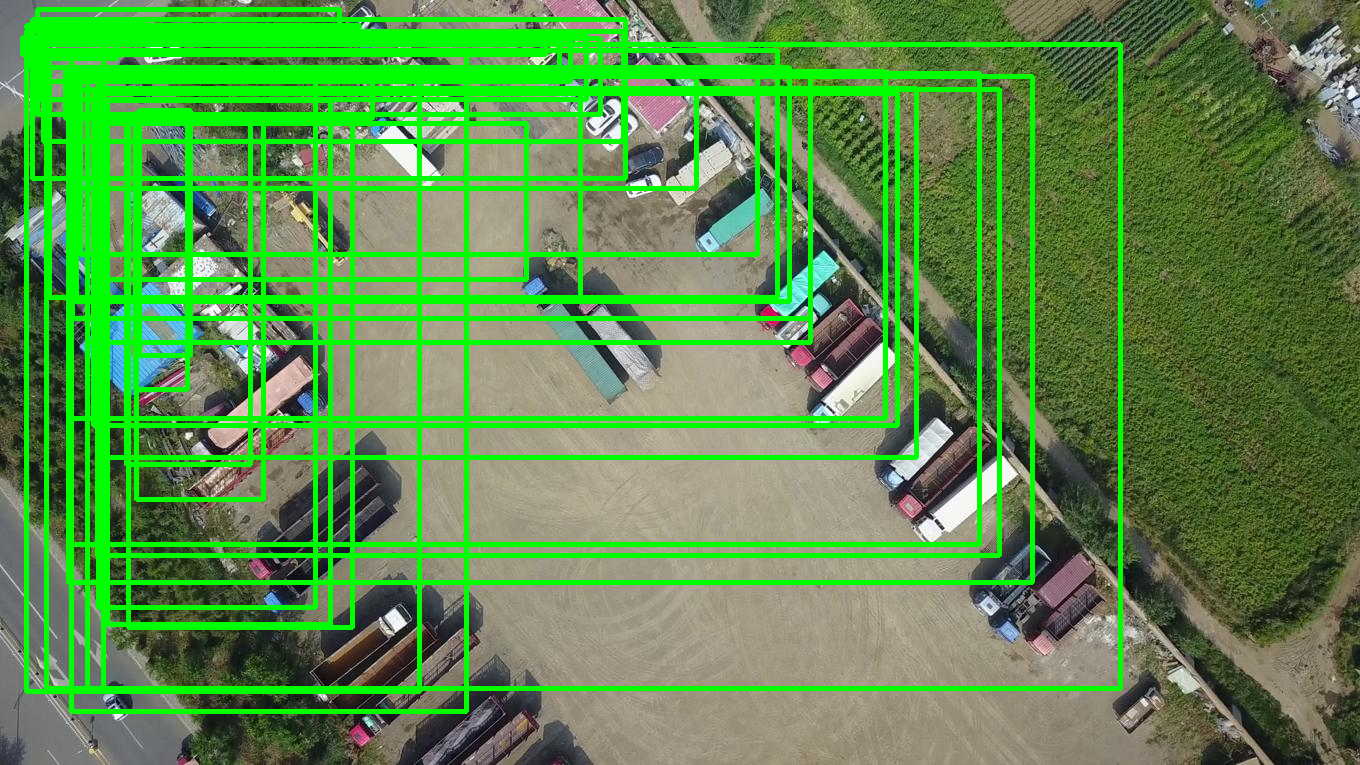

In [58]:
import numpy as np
from tqdm import tqdm
from sahi.utils.cv import read_image_as_pil, visualize_object_predictions
from IPython.display import Image

# export visualizations with ground truths
output_dir = 'sliced_predictions/exp_gt_test'
image = './single_test/images/0000006_06773_d_0000018.jpg'
image_as_pil = read_image_as_pil(image)
color = (0, 255, 0)  # original annotations in green
visual_bbox_gt_thickness = 3
visual_bbox_thickness = 2
visual_text_size = 12
visual_text_thickness = 10
visual_hide_labels = 1
visual_hide_conf = 1
file_name = 'result_gt'
filename_prediction = 'prediction_visual_with_gt'
visual_export_format = 'png'

result = visualize_object_predictions(
    np.ascontiguousarray(image_as_pil),
    object_prediction_list= object_prediction_gt_list,
    rect_th=visual_bbox_gt_thickness,
    text_size=visual_text_size,
    text_th=visual_text_thickness,
    color=color,
    hide_labels=visual_hide_labels,
    hide_conf=visual_hide_conf,
    output_dir=output_dir,
    file_name=filename_prediction,
    export_format= visual_export_format,
)
Image(f'sliced_predictions/exp_gt_test/prediction_visual_with_gt.png')